In [1]:
import pandas as pd
import os.path
from core.util.math import compute_ft
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from enum import Enum
from scipy.linalg import sqrtm

from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string

from logic.pulsed.predefined_generate_methods.multi_nv_methods import DQTAltModes, TomoRotations, TomoInit

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

0

0

# Library

In [2]:
def setup_clear_plots(n_plots):
    n_cur = qdplotlogic.number_of_plots
    for i in range(n_cur):
        n_cur_i = qdplotlogic.number_of_plots
        if n_cur_i >= 1:
            # removing without arguments seems buggy
            qdplotlogic.remove_plot(n_cur_i-1)
    
    for i in range(n_plots):
        qdplotlogic.add_plot()
def extract_num_from_path(file):
    fname = os.path.basename(file)
    res = Tk_string.find_num_in_str(fname)
    
    return res

"""
# delete if Tk_file import works
def load_pulsed_result(fname):

    data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "z2", "std1", "std2"])
    if pd.isnull(data.iloc[0, -1]):
        data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "std1"])
    meta = Tk_file.load_pulsed_metadata(fname)

    mes = {'data': data,
           'file': fname}
    mes = {**mes, **meta}

    return mes
"""
def do_fit(p_mes, fit_y='delta', fit_method='sine', edit_params=None):
    fitter = pulsedmeasurementlogic.fc   
    
    if edit_params:
        for ov_param in edit_params:
            
            if ov_param.name in fitter.fit_list[fit_method]['parameters'].keys():
                fitter.fit_list[fit_method]['use_settings'][ov_param.name] = True
                fitter.fit_list[fit_method]['parameters'][ov_param.name] = ov_param
                
                #logger.debug(f"Overwriting fit param {ov_param.name}: {ov_param}")

    fitter.clear_result()
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """

    if fit_y == 'delta':
        data = np.asarray(p_mes['data']['tau']), np.asarray(delta_or_z1(p_mes))
    elif fit_y == 'z1':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z1'])
    elif fit_y == 'z2':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z2'])
    else:
        raise ValueError
    
 
    
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    # params [lmfit::Parameters] and derived params [dict]
    # considered in _get_fit()
    
    # get values of fitted model
    model = fitter.fit_list[fit_method]['make_model']()[0]
    x_domain = np.asarray(p_mes['data']['tau'])
    x_domain = np.linspace(np.min(x_domain), np.max(x_domain), 1000)
    y = model.eval(x=x_domain, params=result.params)
    fit_vals = {'x': x_domain, 
                'y': y}
    
    full_result = {**result.params, **result.result_str_dict}
    p_mes['fit_res'] = full_result
    p_mes['fit_values'] = fit_vals

def get_z(p_mes, mode='z1'):
    # mode: z1, z2, delta, (+_norm)
    try:
        has_z2 = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False
            
        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)
        
        if mode == 'z1':
            return z1
        elif mode == 'z1_norm':
            return z1_norm
        elif mode == 'z2' or mode == 'z2_norm' or mode=='delta' or mode=='delta_norm':
            if has_z2:
                z2 = p_mes['data']['z2']
                delta = (z1-z2)
                delta_norm = delta/np.average(z1)
            else:
                raise KeyError
                
            if mode == 'z2':
                return z2
            if mode == 'z2_norm':
                return z2/np.average(z2)
            if mode == 'delta':
                return delta
            if mode == 'delta_norm':
                return delta_norm
        else:
            raise ValueError(f"Unknown mode: {mode}")  

    except:
        logger.exception(f"Loading of {mode} from file {p_mes['file']} failed")
        raise  

def delta_or_z1(p_mes, norm=False):
    try:
        has_z2 = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False

        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)

        if has_z2:
            z2 = p_mes['data']['z2']
            delta = (z1-z2)
            delta_norm = delta/np.average(z1)

            if norm:
                return delta_norm
            else:
                return delta

        if norm:
            return z1_norm
        return z1
    except:
        logger.exception(f"Loading of file {p_mes['file']} failed")
        raise
        


def pulsed_series_2_array(pulsed_series, idx_var_y=None, ordered_y=True):
    y2d = []
    z1s, z2s = [], []
    x2d = []

    for p in p_raw:
        try:
            z1 = p['data']['z1']
            try:
                z2 = p['data']['z2']
            except:
                z2 = np.nan
            # set x axis of 2d plot
            tau = p['data']['tau']
            # set y axis of 2d plot
            idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_y != None:
                var_file = float(extract_num_from_path(p['file'])[idx_var_y])
            # set y axis as time of mes
            if idx_var_y == None:
                var_file = p['date'].timestamp() - p_raw[0]['date'].timestamp()
            #logger.info(f"1st: tau {tau}, x2d {x2d}")
            if len(x2d) > 0:
                err = f"Data in file {p['file']} doesn't share tau axis"
                try:
                    if not np.all(x2d == tau):
                        raise ValueError(err)
                except:
                    logger.exception(err)
                    raise


            x2d = tau
            #logger.info(f"tau {tau}, x2d {x2d}")
            y2d.append(var_file)
            z1s.append(z1)
            z2s.append(z2)

        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise



    z1s = np.asarray(z1s)
    z2s = np.asarray(z2s)

    x2d = np.asarray(x2d)
    y2d = np.asarray(y2d)
    
    if ordered_y:
        y2d,  z1s, z2s = np.sort(y2d), z1s[y2d.argsort()], z2s[y2d.argsort()]
    
    return x2d, y2d, z1s, z2s


def pulsed_series_2_1d_fit_array(pulsed_series, fit_meth, fit_on, fit_vals,
                                 idx_var_x=None, ordered_x=True):
    
    x,y, y2, y3 = [], [], [], []
    dy = []
    
    for p in pulsed_series:
        try:
            # set x axis of 1d plot
            # idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_x:
                var_file = float(extract_num_from_path(p['file'])[idx_var_x])
            # set y axis as time of mes
            else:
                var_file = p['date'].timestamp() - pulsed_series[0]['date'].timestamp()
            x.append(var_file)
            
            # looks for fit params to overwirte
            edit_params = None
            if 'fit_edit_params' in p.keys():
                edit_params = p['fit_edit_params']
            
            # fit result on y axis
            do_fit(p, fit_y=fit_on, fit_method=fit_meth, edit_params=edit_params)

            y.append(_get_fit(p, 0, error=False, cust_vals=fit_vals))
            dy.append(_get_fit(p, 0, error=True, cust_vals=fit_vals))
            y2.append(_get_fit(p, 1, error=False, cust_vals=fit_vals))
            y3.append(_get_fit(p, 2, error=False, cust_vals=fit_vals))


        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise

    x, y, y2, y3, dy = np.asarray(x), np.asarray(y), np.asarray(y2),  np.asarray(y3), np.asarray(dy)
    if ordered_x:
        x, y, y2, y3, dy = np.sort(x), y[x.argsort()], y2[x.argsort()], y3[x.argsort()], dy[x.argsort()]
    
    return x, y, y2, y3, dy

def _get_fit(p, y_idx=0, error=False, cust_vals=None):
    import lmfit
    fit_vals = ['Lifetime', 'Contrast', 'Frequency']
    if cust_vals:
        fit_vals = cust_vals
    try:
        param = p['fit_res'][fit_vals[y_idx]]
        if isinstance(param, lmfit.parameter.Parameter):
            fit_quant = 'stderr' if error else 'value'
            return getattr(param, fit_quant)
        elif isinstance(param, dict):
            fit_quant = 'error' if error else 'value'
            return param[fit_quant]
        else:
            raise ValueError(f"Didn't understand fit param type: {type(params)}")
    except:
        return -1
0

0

In [3]:
# auto nv char

In [4]:
import pandas as pd
import difflib


def overwrite_poi_from_foldername(p_mes):
    # needed, if "Active POI:" property in .dat file is buggy
    path = os.path.normpath(p_mes['file'])
    poi = path.split(os.sep)[-2][:]
    try:
        poi = 'nv_' + poi.rsplit('nv_',1)[1]
    except IndexError:
        return
    #return poi
    #poi.rsplit(poi, '')
    
    if 'Pulsed' in poi:
        return
    else:
        p_mes['poi'] = poi
        return poi

def find_param_file(p_mes):
    return Tk_file.find_param_file(p_mes)

def extract_params_from_file(header_lines):

    header_flat = ' '.join([line for line in header_lines])
    text = header_flat

    # time of experiment
    m = re.search('on(.+?)\n', text)
    if m:
        found = m.group(1)
    date = pd.to_datetime(found, dayfirst=True)

    # poi
    m = re.search('POI:(.+?)\n', text)
    if m:
        found = m.group(1)
    poi = found.lstrip()

    meta = {'date': date,
            'poi': poi}
    return meta

    
def load_param_file(fname):
        
    return Tk_file.load_param_file(fname)

def load_pulsed_params(p_mes):
    fname = find_param_file(p_mes)
    return load_param_file(fname)
    
def decay_fit(p_in, name_timeconst='T2_he', fit_meth='exp_decay'):
    y_val_idx = None
    fit_on = 'delta'
    fit_vals = ['Lifetime', 'None', 'None']
    
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)
    for p in p_in:
        p[f"fit_res_{name_timeconst}"] = p['fit_res']

def nv_class_for_exp(p_in, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    for p in p_in:
        try:
            f_mw = load_pulsed_params(p)['microwave_frequency']
            p['exp_on_fres'] = NVClass(find_closest(f_mw, f_res_classes=f_res_classes))
        except KeyError:
            pass
            

def find_best_lor_fit(p_in, fit_meths=['lor_dip', 'lor_dip_2x']):
    
    for i, fmeth in enumerate(fit_meths):
        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fmeth
        fit_vals = ['Position 0', 'Position 1', 'Position 2']    
        if i == 0:
            fit_vals[0] = 'Position'
        
        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                        idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fmeth}"] = p['fit_res']

        """
        # fit_res is updated after

        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fit_meths[1]
        fit_vals = ['Position 0', 'Position 1', 'None']    

        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                    fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fit_meths[1]}"] = p['fit_res']
        """

from enum import IntEnum        
class NVClass(IntEnum):
    NOT_CLASSIFIED = -1
    NO_ODMR = -2
    A = 0
    B = 1
    C = 2
    D = 3

    
def classify_nv_orientation(p_mes, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):
    """
    fit meths should be ordered in the number of nvs they correscpond.
    -> lor_dip, lor_dip_2x => n=[1,2]
    """
    p = p_mes
    nv_class = None
    
    chis = []
    for fit in fit_meths:
        if f"fit_res_{fit}" in p.keys():
            chis.append(p[f"fit_res_{fit}"]['chi_sqr']['value'])
    
    i_chi = np.argmin(np.asarray(chis)) 
    n_nv = i_chi + 1
    nv_classes = []
    
    for i_line in range(0, n_nv):
        if n_nv <= 1:
            f_res_i = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        else:    
            f_res_i = p[f"fit_res_{fit_meths[i_chi]}"][f'Position {i_line}']['value']

        nv_class_i = find_closest(f_res_i, f_res_classes=f_res_classes)
        nv_classes.append(NVClass(nv_class_i))
    
    for i_line in range(0, n_nv):
        if not classify_has_odmr(p, nv_classes, fit_meths=fit_meths, snr_thresh=snr_thresh)[i_line]:
            nv_classes[i_line] = NVClass.NO_ODMR

    """
    # smaller chisqr: better fit
    if chisqr_0 < chisqr_1:
        f_res = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        nv_class = [NVClass(find_closest(f_res, f_res_classes=f_res_classes))]
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class = [NVClass.NO_ODMR]

    else:
        f_res_0 = p[f"fit_res_{fit_meths[1]}"]['Position 0']['value']
        f_res_1 = p[f"fit_res_{fit_meths[1]}"]['Position 1']['value']
        nv_class_0 = find_closest(f_res_0, f_res_classes=f_res_classes)
        nv_class_1 = find_closest(f_res_1, f_res_classes=f_res_classes)

        nv_class = [NVClass(nv_class_0), NVClass(nv_class_1)]

        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class[0] = NVClass.NO_ODMR
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[1]:
            nv_class[1] = NVClass.NO_ODMR
    """
    return nv_classes
        
def classify_nv_orientation_all(p_in, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):  
    for p in p_in:
        try:
            nv_class = classify_nv_orientation(p, fit_meths=fit_meths, f_res_classes=f_res_classes, snr_thresh=snr_thresh)
            p['nv_class'] = nv_class
        except:
            raise ValueError(f"Failed classifiying file: {p_in['fname']}")

def calc_odmr_snr_areal(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], linewidth_expect=[3e6, 50e6]):
    
    def punish_wrong_linewidth(fwhm, linewidth_limit=[0,np.inf]):
        if fwhm < linewidth_limit[0] or fwhm > linewidth_limit[1]:
            return fwhm * 0.05
        
        return fwhm
        
    p = p_mes
    n_fres = len(([int(c) for c in nv_class]))
  
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        contr_single = p[f"fit_res_{fit_meths[0]}"]['Contrast']['value']
        contr0 = p[f"fit_res_{fit_meths[1]}"]['Contrast 0']['value']
        contr1 = p[f"fit_res_{fit_meths[1]}"]['Contrast 1']['value']
        fwhm_single = p[f"fit_res_{fit_meths[0]}"]['FWHM']['value']
        fwhm_0 = p[f"fit_res_{fit_meths[1]}"]['FWHM 0']['value']
        fwhm_1 = p[f"fit_res_{fit_meths[1]}"]['FWHM 1']['value']
        y = p['data']['z1']
        
        # todo: ugly hard coded punishment
        fwhm_single = punish_wrong_linewidth(fwhm_single, linewidth_limit=linewidth_expect)
        fwhm_0 = punish_wrong_linewidth(fwhm_0, linewidth_limit=linewidth_expect)
        fwhm_1 = punish_wrong_linewidth(fwhm_1, linewidth_limit=linewidth_expect)
        
        
        signal_single = contr_single * fwhm_single
        signal0 = contr0 * fwhm_0
        signal1 = contr1 * fwhm_1
        
        f_sampling = p['data']['tau'][1] - p['data']['tau'][0]
        # noise in units of contrast
        
        noise_c = 1*np.std(y)/np.mean(y)*100
        noise_area = noise_c * f_sampling
        
        #logger.debug(f"noise: {noise_c}/{noise_area}, signal area: {signal_single}/ {signal0} / {signal1}")
        #logger.debug(f"noise: {noise_c}/{noise_area/1e6}, fwhm: {fwhm_single/1e6}/ {fwhm_0/1e6} / {fwhm_1/1e6}, \
        #             contr {contr_single}, {contr0}, {contr1}")
        
        
        if n_fres <= 1:
            return [signal_single/noise_area] 
        elif n_fres == 2:
            signal = [None, None]
            signal[0] = signal0/noise_area
            signal[1] = signal1/noise_area
            
            return signal
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
def classify_has_odmr(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], snr_thresh=10):
    """
    Compares the fit area against the one from the noise signal
    """
    p = p_mes
    found_odmr = None
 
    n_fres = len(([int(c) for c in nv_class]))
    #logger.debug(f"Got nv class {nv_class} of len {n_fres}")
    
    
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():

        
        if n_fres <= 1:
            signal_single = calc_odmr_snr_areal(p, nv_class, fit_meths)[0]
            found_odmr = [True] if signal_single > snr_thresh else [False]
        elif n_fres == 2:
            signal0, signal1 = calc_odmr_snr_areal(p, nv_class, fit_meths)
            
            found_odmr = [False, False]
            if signal0 > snr_thresh:
                found_odmr[0] = True
            if signal1 > snr_thresh:
                found_odmr[1] = True
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
    return found_odmr  
        

def get_chisqr(p_mes, fit_meths=['lor_dip', 'lor_dip_2x']):
    p = p_mes
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        chisqr_0 = p[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
        chisqr_1 = p[f"fit_res_{fit_meths[1]}"]['chi_sqr']['value']
            
        idx_best_fit = np.argmin([chisqr_0, chisqr_1])
        return np.min([chisqr_0, chisqr_1]), idx_best_fit
    
def find_closest(f_res, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    return np.argmin(np.abs(f_res - np.asarray(f_res_classes)))
        
def get_n_odmr_lines(p_mes):   
    
    p = p_mes
    nv_class = p['nv_class']
    nv_class_unique = set(nv_class)
    n_odmr_lines = len([c for c in nv_class_unique if int(c) >= 0])
    
    return n_odmr_lines

def get_mes_for_nv(poi, all_mes, exp_name=None, nv_class=None):
    
    def by_name(p_mes):
        found = False
        
        if exp_name == None and nv_class == None:
            if p_mes['poi'] == poi:
                found = True
        elif exp_name == None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        elif exp_name != None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class and p_mes['experiment_name'] == exp_name:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        else:
            found = True if p_mes['poi'] == poi and p_mes['experiment_name'] == exp_name else False
        
        return found
    
    #if nv_class != None:
    #    logger.debug(f"Called exp_name: {exp_name} nv_class {nv_class}")
            
    return list(filter(by_name, all_mes))

def create_table(p_in_odmr, p_in_dd=[], name_tc_dd=['T2_he', 'T2_xy8'], name_exp_dd=['hahn_echo', 'xy8_n']):
    """
    From lists of basis 'measurement per row' compile an output table with 'nv characteristics' per row
    """
    table = []
    
    p_in_dd_flat = []
    [p_in_dd_flat.extend(p_list) for p_list in p_in_dd] 
    p_in_dd = p_in_dd_flat
        
    for i, p in enumerate(p_in_odmr):
        
        # ODMR
        nv_class = p['nv_class']
        nv_class_unique = set(nv_class) 
        
        # for pretty print, don't repeat non-classified results in output string
        nv_class_str = [c.name for c in nv_class_unique]
        if len(nv_class_str) > 1:
            nv_class_str = [c.name for c in nv_class_unique if int(c) >= 0]
        nv_class_str = str(nv_class_str)
        
        n_odmr_lines = get_n_odmr_lines(p)
        
        fit_chisqr, _ = get_chisqr(p)
        fit_snr_list = calc_odmr_snr_areal(p, nv_class)
        fit_snr_0 = None
        fit_snr_1 = None
        if len(fit_snr_list) == 1:
            fit_snr_0 = fit_snr_list[0]
        elif len(fit_snr_list) == 2:
            fit_snr_0 = fit_snr_list[0]
            fit_snr_1 = fit_snr_list[1]
            
        
        row = {'idx': i,
               'poi': p['poi'], 
               'nv_class': nv_class_str, 
               'nv_class_raw': nv_class, 
               'n_odmr': n_odmr_lines,
               'odmr_chi_sqr': fit_chisqr,
               'date_odmr': p['date']}
        #"""
        if fit_snr_0:
            row['snr_0'] = fit_snr_0
        if fit_snr_1:
            row['snr_1'] = fit_snr_1
        #""" 
        
        # HAHN ECHO
        #for i, exp_list in enumerate(p_in_dd):
        for i, exp_name in enumerate(name_exp_dd):
            try:
                classes = [val for val in NVClass]
                for nv_c in classes:
                    p_dd = get_mes_for_nv(p['poi'], p_in_dd, exp_name, nv_c)
                    val_class = nv_c #if (nv_c != NVClass.) else None 
                    if len(p_dd) == 1:
                        nv_class = p_dd[0]['exp_on_fres'].name
                        label = f'{name_tc_dd[i]} (us)'
                        val = [(1e6*p_dd[0][f"fit_res_{name_tc_dd[i]}"]['Lifetime']['value'], val_class)]
                        if label not in row.keys():
                            row[label] = val                                
                        else:
                            row[label] = row[label] + val
                        #row[f'{name_tc_dd[i]}_nv_class'] = nv_class
                    elif len(p_dd) == 0:
                        pass
                    else:
                        logger.warning(f"Found and ignored > 1 he files for poi {p['poi']}. Filter while loading data!")
            except:
                logger.exception(f"Error on poi {p['poi']}, exp: {exp_name}: ")
                
        table.append(row)
    
    df = pd.DataFrame(table)
      
    return df

def handle_duplicate_all_mes(all_p_mes, mode='newer'):
    new_all = copy.deepcopy(all_p_mes)
    for p in all_p_mes:
        len_old = len(new_all)
        new_all = handle_duplicate_mes(p, new_all, mode=mode)
        #logger.debug(f"for {p['poi']}, {p['date']}, {p['experiment_name']}. len: {len_old} => {len(new_all)}")
    return new_all


def handle_duplicate_mes(p_mes, all_p_mes, mode='newer'):
    # delte duplicates and add to 'all mes' list 
    
    pois = [p['poi'] for p in all_p_mes]
    # for performance, skip if no decision can be made
    if p_mes['poi'] not in pois:
        return all_p_mes
    if p_mes['experiment_name'] == None:
        return all_p_mes
    
    def newer(ex_mes):
        """
        Sort out (return False) elements with same poi && experiment name, but older date
        """
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            # break if on different nv class
            #"""
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return True
            #""" 
            if ex_mes['date'] > p_mes['date']:
                return True
            return False
        else:
            return True
    
    def is_dupl(ex_mes):
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return False
            if ex_mes['date'] > p_mes['date']:
                return False
            return True
            
        return False
        
    
    if mode == 'newer':
        # delete older mes with same poi && name && orientation (if available)
        all_p_mes = list(filter(newer, all_p_mes))
    elif mode == 'all':
        pass
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    if mode == 'newer' or mode == 'all':
        if not any(map(is_dupl, all_p_mes)):
            all_p_mes.append(p_mes)    
    
    return all_p_mes

def create_header_comment(settings_dict):
    out_str = f""
    date = datetime.datetime.now().strftime("%Y/%m/%d, %H:%M:%S \n")
    out_str = f"# analysis on: {date}"
    for key, val in settings_dict.items():
        out_str += f"# {key}: {val}"
        out_str += "\n"
    
    return out_str

from collections import Iterable
def float2string(input):
    """convert float to string for printing
    """
    if isinstance(input, Iterable):
        return list(map(float2string, input))
    else:
        if input is None:
            return None
        else:
            if isinstance(input, NVClass):
                return f"{input.name}"
            elif float(input).is_integer():
                return "{}".format(input)
            else:
                return "{:.2f}".format(input)

def mean_of_list(cell):
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        return np.nanmean(list(map(mean_of_list, cell)))
    else:
        if cell is None:
            return 0
        else:
            if isinstance(cell, NVClass):
                return np.nan
            else:
                return float(cell)

def flatten_floats_only(cell):
    def _flatten(cell):
        if isinstance(cell, Iterable):
            #logger.debug(f"Iterable: {cell}")
            a = list(map(_flatten, cell))

            #a = [item for sublist in a for item in sublist]
            return a
        else:
            if cell is None:
                return None
            else:
                if isinstance(cell, NVClass):
                    return None
                else:
                    return float(cell)
    
    a = _flatten(cell)
    a = [item for sublist in a for item in sublist]
    a = [item for sublist in a for item in sublist]
    a = [item for item in a if item != None]
    return a
            
def mean_of_list_2(cell):
    # non recursive, slightly less powerfull
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        new_cell = []
        for el in cell:
            if isinstance(el, NVClass):
                el = np.nan
            else:
                el = el
            new_cell.append(el)
                    
        return np.average(np.nanmean(new_cell).flatten())
    else:
        return float(cell)
    
def sort_by_key(df, column, key, ascending=False, drop_nan=False):
    # no idea why not working
    #return df.loc[(df[column].map(key)).argsort()]
    
    df[f'{str(column)}_temp'] = df[column].map(key)
    df = df.sort_values(by=f"{str(column)}_temp")
    if drop_nan:
        df = df.dropna(subset=[column])
    df.drop(f"{str(column)}_temp", axis=1)
    
    if ascending:
        return df[::-1]
    return df


def plot_odmr(p_mes, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9],
              fit_meths=['lor_dip', 'lor_dip_2x'], y_offset=0,
              fig=None, no_nvclass_legend=False, no_poi_legend=False):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']
    fit_chisqr = p_mes[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
    nv_class = p_mes['nv_class']
    odmr_snr = calc_odmr_snr_areal(p_mes, nv_class)

    x = np.asarray(p_mes['data']['tau'])
    y = p_mes['data']['z1'] + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
        
    label = f"{poi}" if not no_poi_legend else None
    snr_str = f"{odmr_snr[0]:.1f}/ {odmr_snr[1]:.1f}" if len(odmr_snr) == 2 else f"{odmr_snr}"
    title = fr"class= {[c.name for c in nv_class]}, snr= {snr_str}, $\chi^2$= {fit_chisqr:.3f}"
    
    plt.autoscale(True)
    plt.plot(x/1e6,y, label=label, marker="")
    plt.title(title)
    
    # lines for NV orientation classes
    for i, f in enumerate(f_res_classes):
        if not no_nvclass_legend:
            plt.axvline(f/1e6, label=f"{NVClass(i).name}", alpha=0.4+i*0.1, color='grey')
        else:
            plt.axvline(f/1e6, alpha=0.5, color='grey')
    # plot estimated noise level used for "no odmr" classification
    noise = 1*np.std(y)
    mean = np.median(y)
    y0,y1 = mean - noise/2, mean + noise/2
    plt.fill_between(x/1e6, y0, y1, alpha=0.2, color='orange')

    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.autoscale(False)
    plt.plot(x/1e6, y + y_offset, marker="", color='orange', alpha=0.8)    #plt.autoscale(True)
    plt.xlabel(r"f (MHz)")
    
def plot_decay(p_mes, exp_name="T2_he",
              fit_meth='decay_exp', y_offset=0,
              fig=None):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']

    x = p_mes['data']['tau']
    delta = p_mes['data']['z1'] - p_mes['data']['z2']
    y = delta + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
    
    t2 = p_mes[f'fit_res_{exp_name}']['Lifetime']['value']
    fit_offset = p_mes[f'fit_res_{exp_name}']['offset'].value
    fit_ampl =  p_mes[f'fit_res_{exp_name}']['amplitude'].value
    label = f"{p_mes['exp_on_fres'].name}: {exp_name}= {1e6*t2:.2f} us, ampl= {fit_ampl:.3f}"
    if fit_offset != 0.:
        label += f"offset= {fit_offset:.3f}"
    
    
    title = f"{poi}"
    plt.plot(1e6*x,y, label=label, marker="")
    plt.title(title)
    plt.xlabel(r"t ($\mu s$)")
    
    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.plot(1e6*x, y + y_offset, marker="", color='orange', alpha=0.8)


0

0

# Load qudi pulsed data

In [ ]:
fname = r"C:\Software\qudi_data\optimal_control_assets\20220817_1_guessFromReisserMsc_penalty_fac=100" + "\\" \
        + "opt_res_fom.txt"
        #+ "20220510-1721-54_ramsey_crosstalk_ampl2=150.0mV_pulsed_measurement.dat" 

#fname = r"E:\Data\2022\01\20220104\PulsedMeasurement\t2_he_all_roi\roi_south_of_wire\nv_nv_mayd_20211223_47_triple\\20220108-0530-36_podmr_coarse_nv_nv_mayd_20211223_47_pulsed_measurement.dat"
try:
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
except:
    logger.expcetion("")

fname

In [ ]:
# helps sometimes to get output from print - nevertheless need the cell run 5-10 times!
old_stdout = sys.stdout
old_stdout

# Plot in qudi plot

Need to activate qdplotgui first!

## Only z1

In [ ]:
plot_mode = "z1"

x = np.asarray(p_data['data']['tau'])
z1 =  np.asarray(p_data['data'][plot_mode])
z2 = None
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(fft_x, fft_delta, plot_index=1)


In [ ]:
p_data['data']

## Alternating: z1,z2; Delta (z1-z2); FFT(Delta) trace

In [ ]:
x = np.asarray(p_data['data']['tau'])
z1 =  np.asarray(p_data['data']['z1'])
z2 = np.asarray(p_data['data']['z2'])
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


## Double alternating

Four z per tau [(tau_i, tau_i, tau_i, tau_i), (tau_i+1, tau_i+1, ...), ..]:


    tau_i_1: normal        | -> z1  
    tau_i_2: normal 3pi2   |
    tau_i_3: no DEER pi    | -> z2
    tau_i_4: no DEER 3pi2  |




In [ ]:
x = np.asarray(p_data['tau'])[::2]
z_raw_1 =  np.asarray(p_data['z1'])   # tau_i_1, tau_i_3
z_raw_2 = np.asarray(p_data['z2'])    # tau_i_2, tau_i_4
delta_raw = z_raw_1-z_raw_2
z1 = delta_raw[::2]  # deer
z2 = delta_raw[1::2] # no deer
delta = z1-z2

fft_x, fft_z1 = compute_ft(x_val=x,
                          y_val=z1)
fft_x, fft_z2 = compute_ft(x_val=x,
                          y_val=z2)

setup_clear_plots(3)

#qdplotlogic.set_data(x, z1)
#qdplotlogic.set_data(x, z2, clear_old=False)
#qdplotlogic.set_title("Z1: DEER, Z2: no DEER")

qdplotlogic.set_data(x, z2)
qdplotlogic.set_data(x, z1, clear_old=False)
qdplotlogic.set_title("Z1: no DEER, Z2: DEER")

qdplotlogic.set_data(fft_x, fft_z1, plot_index=1)
qdplotlogic.set_title("FFT(DEER)", plot_index=1)
qdplotlogic.set_data(fft_x, fft_z2, plot_index=2)
qdplotlogic.set_title("FFT(no DEER)", plot_index=2)
0

### Single z1, z2 for deer, no deer

In [ ]:
detail_nodeer_plot = False
detail_deer_plot = not detail_nodeer_plot

# plot pi2, 3pi2: DEER
z_deer = z_raw_1[::2]
z_deer_3pi2 = z_raw_2[::2]

#  plot pi2, 3pi2: no DEER
z_nodeer = z_raw_1[1::2]
z_nodeer_3pi2 = z_raw_2[1::2]

if detail_deer_plot:
    z1 = z_deer
    z2 = z_deer_3pi2
if detail_nodeer_plot:
    z1 = z_nodeer
    z2 = z_nodeer_3pi2

setup_clear_plots(5)
    
qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)
qdplotlogic.set_title("Z1: pi2 read, Z2: 3pi2 read")
qdplotlogic.set_data(x, z1-z2, plot_index=1)
qdplotlogic.set_title("Delta: Z1-Z2", plot_index=1)

fft_x, fft_z1 = compute_ft(x_val=x,
                          y_val=z1)
fft_x, fft_z2 = compute_ft(x_val=x,
                          y_val=z2)
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(fft_x, fft_z1, plot_index=2)
qdplotlogic.set_title("FFT(Z1)", plot_index=2)
qdplotlogic.set_data(fft_x, fft_z2, plot_index=3)
qdplotlogic.set_title("FFT(Z2)", plot_index=3)
qdplotlogic.set_data(fft_x, fft_delta, plot_index=4)
qdplotlogic.set_title("FFT(Z1-Z2)", plot_index=4)

# Qudi data series

## Load multiple 1d

In [ ]:
p_raw, x, y, fnames = [], [], [], []

inpath = r"E:\Data\2022\05\20220502\PulsedMeasurement\shaped\duplicate_for_plot"
#inpath = r"E:\Data\2021\10\20211026\PulsedMeasurement\rnovel_vs_p_1"

filter_strs = ['pulsed_measurement', '.dat']
filter_strs += ['deer']

fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)


for f in fnames:
    #p_i = Tk_file.load_pulsed_metadata(f)
    #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
    #p_i = Tk_file.load_pulsed_result(f)
    p_i = Tk_file.load_pulsed_result(f)
    p_raw.append(p_i)

data = load_pulsed_result(p_raw[0]['file'])

len(p_raw)

In [ ]:
inpath

In [ ]:
p_raw[-1]['date'], len(fnames)

In [ ]:
p_raw[-1]['file']

## Load 2d data series

that can be placed in a 2d array, because they share x axis

In [22]:
p_raw, x, y, fnames = [], [], [], []

inpath = r"D:\Data\2022\09\20220902\PulsedMeasurement\stability_test_3"

filter_strs = ['pulsed_measurement', '.dat']
#filter_strs += ['on2=0']
fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

for f in fnames:
    p_i = Tk_file.load_pulsed_result(f)
    p_raw.append(p_i)

data = Tk_file.load_pulsed_result(p_raw[0]['file'])
#Put onto 2d grid: Every row a single pulsed result
x, y, z1s, z2s = pulsed_series_2_array(p_raw, idx_var_y=None, ordered_y=True)
p_raw[-1]['file']

'D:\\Data\\2022\\09\\20220902\\PulsedMeasurement\\stability_test_3/20220904-2329-30_Ramsey_pulsed_measurement.dat'

In [ ]:
p_raw[-1]['date'], p_raw[0]['date'], y

In [25]:
x

array([0.00e+00, 2.00e-08, 4.00e-08, 6.00e-08, 8.00e-08, 1.00e-07,
       1.20e-07, 1.40e-07, 1.60e-07, 1.80e-07, 2.00e-07, 2.20e-07,
       2.40e-07, 2.60e-07, 2.80e-07, 3.00e-07, 3.20e-07, 3.40e-07,
       3.60e-07, 3.80e-07, 4.00e-07, 4.20e-07, 4.40e-07, 4.60e-07,
       4.80e-07, 5.00e-07, 5.20e-07, 5.40e-07, 5.60e-07, 5.80e-07,
       6.00e-07, 6.20e-07, 6.40e-07, 6.60e-07, 6.80e-07, 7.00e-07,
       7.20e-07, 7.40e-07, 7.60e-07, 7.80e-07, 8.00e-07, 8.20e-07,
       8.40e-07, 8.60e-07, 8.80e-07, 9.00e-07, 9.20e-07, 9.40e-07,
       9.60e-07, 9.80e-07, 1.00e-06, 1.02e-06, 1.04e-06, 1.06e-06,
       1.08e-06, 1.10e-06, 1.12e-06, 1.14e-06, 1.16e-06, 1.18e-06,
       1.20e-06, 1.22e-06, 1.24e-06, 1.26e-06, 1.28e-06, 1.30e-06,
       1.32e-06, 1.34e-06, 1.36e-06, 1.38e-06, 1.40e-06, 1.42e-06,
       1.44e-06, 1.46e-06, 1.48e-06, 1.50e-06, 1.52e-06, 1.54e-06,
       1.56e-06, 1.58e-06])

In [ ]:
len(p_raw)
p_raw[0]['exp_params']['read_phase']

In [ ]:
# Load 2d with 2 seperate measurements per row

In [6]:
p_raw, x, y, fnames = [], [], [], []

try:
    inpath = r"E:\Data\2022\05\20220516\PulsedMeasurement\cnot_vs_readphase_1"

    filter_strs = ['pulsed_measurement', '.dat']
    filter_strs += ['on2=0']
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)

    data = Tk_file.load_pulsed_result(p_raw[0]['file'])
    #Put onto 2d grid: Every row a single pulsed result
    x, y, z1s_1, z2s_1 = pulsed_series_2_array(p_raw, idx_var_y=-3, ordered_y=True)

    p_raw, x, y, fnames = [], [], [], []
    inpath = r"E:\Data\2022\05\20220516\PulsedMeasurement\cnot_vs_readphase_1"

    filter_strs = ['pulsed_measurement', '.dat']
    filter_strs += ['on2=1']
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)

    x, y, z1s_2, z2s_2 = pulsed_series_2_array(p_raw, idx_var_y=-3, ordered_y=True)

    z1s = z1s_1 - z1s_2
    z2s = z2s_1 - z2s_2
except:
    logger.exception("")
0

0

In [ ]:
p_raw[0]['exp_params']['savetag']

## Plot multiple 1d

In [ ]:
def get_pair(pmes, plist, var_key):
    search_params = pmes['exp_params']
    
    found = {}
    for p in plist:
        i_params = p['exp_params']
        if i_params[var_key] == search_params[var_key]:
            found[i_params['savetag']] = p
    
    if len(found) != 2:
        raise ValueError(f"Couldn't find pair. So far: {found.keys()}")
    
    return found
try:
    a = get_pair(p_raw[0], p_raw, 'read_phase')
except:
    logger.exception("")



In [ ]:
from scipy.interpolate import UnivariateSpline


plot_mode = "z2"
offset = 0.1
"""
"21_1",  "20_7", "20_2", "20_4"
for i, mes in enumerate(p_raw):
#    if "20_7, 20_11" in mes['file']:
        x_i = mes['data']['tau']
        y_i = offset*i + get_z(mes, mode=plot_mode)
        poi_id = mes['file'].split('nv_')[2].split("\\")[0]
        plt.plot(x_i, y_i, label=f"{poi_id}")
plt.legend()
"""
#"""
plot_data = []
plt.figure(figsize=(9,5))
try:
    for i, mes in enumerate(p_raw):
        #if "20_4" in mes['file'] or "20_7" in mes['file']  or "20_2" in mes['file']  or "21_1" in mes['file'] :
        #if i==0 or i==len(p_raw)-1 or i%6==0:
        if True:
            x_i = 1e9*np.asarray(mes['data']['tau'])
            y_i = offset*i +  np.asarray(get_z(mes, mode=plot_mode))

            # get data from 2 mes
            """
            mes1 = list(get_pair(mes, p_raw, 'read_phase').values())[0]
            mes2 = list(get_pair(mes, p_raw, 'read_phase').values())[1]
            y_i = offset*i +  np.asarray(get_z(mes1, mode=plot_mode)) - np.asarray(get_z(mes2, mode=plot_mode))
            if any((y_i == x).all() for x in [t[1] for t in plot_data]):  # avoid double plotting of pairs
                continue
            """

            # smooth data
            zipped = sorted(zip(x_i, y_i), key=lambda x: x[0])  # raw data x sometimes reversed
            x_in, y_in = [s[0] for s in zipped],[s[1] for s in zipped]
            spline = UnivariateSpline(x_in, y_in)
            x_smooth_i = np.linspace(np.min(x_i), np.max(x_i), 500)
            y_smooth_i = spline(x_smooth_i)


            poi_id = mes['file']#.split('nv_')[2].split("\\")[0]
            poi_id = int(not(i))

            # colormap
            color=None
            """
            if i==0:
                color = '#a51cb3ff'
            elif i==1:
                color = "#b35a1df7"
            """
            color = plt.cm.plasma(i/len(p_raw))
            #color = plt.cm.tab20(i/len(p_raw))
            
            label= f"{mes['exp_params']['savetag']}"
            #label = f"control= |{poi_id}>"
            #label = f"read_phase= {mes['exp_params']['read_phase']:.1f}"

            plt.scatter(x_i, y_i, label=label, alpha=0.5, color=color)
            plt.plot(x_i, y_i, label='_nolegend_', color=color, marker="", alpha= 0.1)
            #plt.plot(x_smooth_i, y_smooth_i, label='_nolegend_', color=color, marker="", alpha= 0.9)
            #plt.xlim([0,200])

            plot_data.append([x_i,y_i])

    
except:
    logger.exception("")

#"""

#plt.plot(x_i, np)
plt.xlabel("t_evol (ns)")
plt.ylabel("signal")
plt.legend(prop={'size': 8})
plt.show()


# to qudiplotter
for i, data in enumerate(plot_data):
    x_i, y_i = data[0], data[1]
    clear_old = True if i==0 else False
    qdplotlogic.set_data(x_i,y_i, clear_old=clear_old,  plot_index=0)
    if i>0:
        qdplotlogic.set_data(plot_data[i-1][0],-(y_i - plot_data[i-1][1]), clear_old=True,  plot_index=1)
    

0

In [ ]:
plot_data[0]

In [ ]:
mes1['file'], mes2['file']

## Plot 2d color map

In [ ]:
y

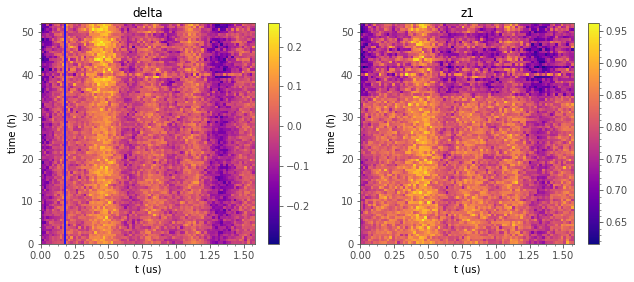

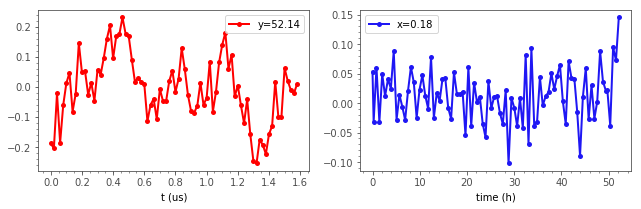

In [29]:
scale_fac = [1e6, 1/3600]
#scale_fac = [1, 1]
#scale_fac = [1e-6, 1]
extent = [x[0]*scale_fac[0], x[-1]*scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
#plot_labels = ["t (us)", "ampl (mV)"]
plot_labels = ["t (us)", "time (h)"]
#plot_labels = ["t (us)", "read phase (deg)"]
#plot_labels = ["depol steps ( )", "df (MHz)"]
#plot_labels = ["depol steps ( )", "sweep speed (MHz/us)"]
#plot_labels = ["depol steps ( )", "dd order (mV)"]


idx_cut_y = -1
idx_cut_x = 9
plot_mode = "delta"  # 'delta_norm'
#plot_mode = "z2"  # 'delta_norm'
cut_mode = "delta_norm"
#cut_mode = "z2"

try:
    try:
        x[idx_cut_x]
    except IndexError:
        idx_cut_x = 0
    try:
        y[idx_cut_y]
    except IndexError:
        idx_cut_y = 0

   
    
    z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]

    if not np.any(np.isnan(z2s[0])):
        if plot_mode == 'delta_norm':
            delta_norm = (z1s-z2s)/np.average(z1s, axis=1)[:,None]
            z2_norm = (z2s)/np.average(z2s, axis=1)[:,None]
            #plot_mode = "z2"
        elif plot_mode =='delta':
            delta_norm = z1s-z2s
        elif plot_mode == 'z2':
            delta_norm = z2s
    else:
        if plot_mode == 'z1_norm':
            z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
            delta_norm = z1_norm


    #plt.figure(figsize=(5,3.5))

    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plt.title(f"{plot_mode}")
    plt.imshow(delta_norm, 
               extent=extent, aspect='auto', origin='lower', cmap="plasma"
              #,vmin=0.14
              #,vmax=0.2
              )

    if cut_mode == "delta_norm":
        plt.axvline(x[idx_cut_x]*scale_fac[0])
        plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.colorbar()


    #plt.ylim(6.6,10)

    plt.subplot(122)
    plt.title("z1")
    plt.imshow(z1s, 
               extent=extent, aspect='auto', origin='lower', cmap="plasma"
              #,vmin=0.85
              )

    if cut_mode == "z1":
        plt.axvline(x[idx_cut_x]*scale_fac[0])
        plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.colorbar()


    plt.tight_layout()
    plt.show()

    # plot cuts
    if cut_mode == "delta_norm":
        zcut = delta_norm
    else:
        zcut = z1s

    plt.figure(figsize=(9,3))
    plt.subplot(121)
    plt.plot(x*scale_fac[0], zcut[idx_cut_y,:], label=f"y={y[idx_cut_y]*scale_fac[1]:.2f}", color='red')
    plt.xlabel(plot_labels[0])
    plt.legend()

    plt.subplot(122)
    plt.plot(y*scale_fac[1], zcut[:,idx_cut_x], label=f"x={x[idx_cut_x]*scale_fac[0]:.2f}")
    plt.xlabel(plot_labels[1])
    plt.legend()



    plt.tight_layout()
    plt.show()
except:
    logger.exception("")

In [ ]:
x[idx_cut_x]*scale_fac[0]

### FFT analysis

In [ ]:
z2s is None

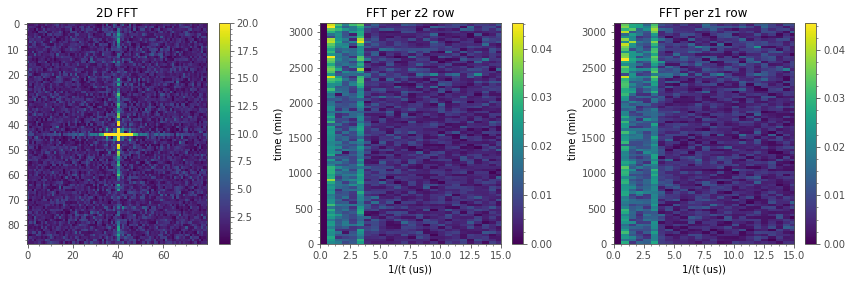

In [13]:
def calc_fft_per_row(x, zs):
    fft_rows = []
    for idx_row, row in enumerate(zs):
        fft_x, fft_delta = compute_ft(x_val=x, y_val=row)
        fft_rows.append(fft_delta)
        
    return fft_x, np.asarray(fft_rows)

def get_z_for_2d(z1s, z2s=None, mode='z1'):
    # mode: z1, z2, delta, (+_norm)
    try:
        has_z2 = True
        if z2s is None:
            has_z2 = False
                    
        if mode == 'z1':
            return z1s
        elif mode == 'z1_norm':
            raise NotImplemented
        elif mode == 'z2' or mode == 'z2_norm' or mode=='delta' or mode=='delta_norm':
            if has_z2:
                delta = (z1s-z2s)
            else:
                raise KeyError
                
            if mode == 'z2':
                return z2s
            if mode == 'z2_norm':
                 raise NotImplemented
            if mode == 'delta':
                return delta
            if mode == 'delta_norm':
                 raise NotImplemented
        else:
            raise ValueError(f"Unknown mode: {mode}")  

    except:
        logger.exception(f"Loading of {mode} failed")
        raise  

plt.figure(figsize=(12,4))
plt.subplot(131)
# 2d fft
ftimage = np.fft.fft2(z1s)
ftimage = np.fft.fftshift(ftimage)
plt.title("2D FFT")
plt.imshow(np.abs(ftimage), vmax=20, aspect='auto')
plt.colorbar()

# fft per line
fft_rows = []
fft_x = None

zs = get_z_for_2d(z1s, z2s, mode=plot_mode)
fft_x, fft_rows= calc_fft_per_row(x, zs)


plt.subplot(132)
plt.title(f"FFT per {plot_mode} row")
extent = [fft_x[0]/scale_fac[0], fft_x[-1]/scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
plt.imshow(fft_rows, origin='lower', extent=extent, aspect='auto'
          #,vmax=0.05
          #,vmin=0.01
          )
plt.xlim([0,15])
plt.ylabel(plot_labels[1])
plt.xlabel(f"1/({plot_labels[0]})")
plt.colorbar()

plt.subplot(133)

fft_rows = []
fft_x = None


zs = get_z_for_2d(z1s, z2s, mode='z1')
fft_x, fft_rows= calc_fft_per_row(x, zs)
    
plt.title(f"FFT per z1 row")
extent = [fft_x[0]/scale_fac[0], fft_x[-1]/scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
plt.imshow(fft_rows, origin='lower', extent=extent, aspect='auto'
          #,vmax=0.05
          #,vmin=0.01
          )
plt.xlim([0,15])
plt.ylabel(plot_labels[1])
plt.xlabel(f"1/({plot_labels[0]})")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:

zs = get_z_for_2d(z1s, z2s, mode='z1')
fft_x, fft_rows_1= calc_fft_per_row(x, zs)
zs = get_z_for_2d(z1s, z2s, mode='z2')
fft_x, fft_rows_2= calc_fft_per_row(x, zs)
fft_rows = fft_rows_1 - fft_rows_2

plt.figure(figsize=(6,4))
plt.title(f"z1-z2 FFT per row")
extent = [fft_x[0]/scale_fac[0], fft_x[-1]/scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
plt.imshow(fft_rows, origin='lower', extent=extent, aspect='auto'
          #,vmax=0.05
          #,vmin=0.01
          )
plt.xlim([0,15])
plt.ylabel(plot_labels[1])
plt.xlabel(f"1/({plot_labels[0]})")
plt.colorbar()

plt.tight_layout()
plt.show()


## Fit on series

In [14]:

#"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
scale_fac_x = [1]
scale_fac_y = [1e-6, 1e-6, 1e-6]
fit_on = 'z2'
fit_meth = 'sine_3x'
fit_vals = ['Frequency 1', 'Frequency 2', 'Frequency 3']
fit_units = ['MHz','MHz', 'MHz']
calc_dxdy_fromto = [False, False, False]
#"""
"""
y_val_idx = None
x_val = "Time"
x_unit = "h"
scale_fac_x = [1/3600.]
scale_fac_y = [1e-6, 1, 1]
fit_on = 'z1'
fit_meth = 'lor_dip'
fit_vals = ['Position', 'Contrast', 'offset']
fit_units = ['MHz','%', 'a.u.']
calc_dxdy_fromto = [False, (0,30), (0,30)]
"""
"""
y_val_idx = -3
x_val = "read phase"
x_unit = "deg"
scale_fac_x = [1]
scale_fac_y = [1, 1e6, 1]
fit_on = 'z2'
fit_meth = 'sine'
fit_vals = ['Amplitude', 'Frequency', 'Frequency 2']
fit_units = ['','MHz', 'MHz']
calc_dxdy_fromto = [False, False, False]
"""
"""
y_val_idx = -1
x_val = "ampl"
x_unit = "mV"
x_val = "sweep speed"
x_unit = "MHz/us"
scale_fac_x = [1]
scale_fac_y = [1, 1, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Amplitude', 'Lifetime', 'Frequency 2']
fit_units = ['','steps', 'MHz']
calc_dxdy_fromto = [(0,-1), False, False]
"""

#scale_fac_x = [1e-3]
#scale_fac_y = [1e6, 1e-6, 1e-6]
#x_val = "df"
#x_unit = "kHz"
"""
y_val_idx = None
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e-6, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'lor_dip_2x'
fit_vals = ['Position 0', 'Position 1', 'None']
fit_units = ['MHz','MHz', 'MHz']
calc_dxdy_fromto = [False, False, False]
"""
"""
y_val_idx = 3
x_val = "idx"
x_unit = ""
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Lifetime', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
"""


'\ny_val_idx = 3\nx_val = "idx"\nx_unit = ""\nscale_fac_x = [1]\nscale_fac_y = [1e9, 1e-6, 1e-6]\nfit_on = \'delta\'\nfit_meth = \'decay_exp\'\nfit_vals = [\'Lifetime\', \'Position 1\', \'None\']\nfit_units = [\'ns\',\'MHz\', \'MHz\']\n'

In [ ]:
fit_vals, scale_fac_y

In [ ]:
p_raw[-1]['date']- p_raw[0]['date'], p_raw[-1]['date'], p_raw[0]['date']

In [15]:
x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)

In [ ]:
def order_similar_fit_res(fit_vals):
    # eg. for fit res f1,f2,f3 => f1<f2<f3
    # makes only sense if results are equivielent!
    y_arr = np.asarray(fit_vals)
    y_arr.sort(axis=0)
    
    return [col for col in y_arr]

y, y2, y3 = order_similar_fit_res([y,y2,y3])


0

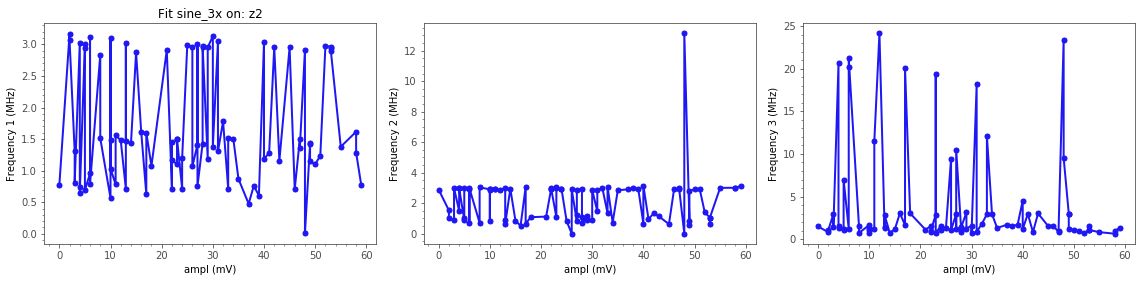

In [16]:
plt.figure(figsize=(16,4))


plt.subplot(131)

#plt.scatter(x,1e6*y)
try:
    raise  # don't plot errorbar
    plt.errorbar(scale_fac_x[0]*x,scale_fac_y[0]*y, 
                yerr=scale_fac_y[0]*dy,
                 ecolor='orange', capsize=5, fmt='o', elinewidth=1, capthick=1)
    y_min = np.min(scale_fac_y[0]*y)
    y_max = np.max(scale_fac_y[0]*y)
    #plt.ylim([y_min-abs(0.1*y_min), y_max+abs(0.1*y_max)])
    
except:
    plt.scatter(scale_fac_x[0]*x,scale_fac_y[0]*y)
plt.plot(scale_fac_x[0]*x,scale_fac_y[0]*y)


plt.title(f"Fit {fit_meth} on: {fit_on}")
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[0]} ({fit_units[0]})")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (MHz)")
#plt.xlim(0.5,2)
if calc_dxdy_fromto[0]:
    idx_slope_from = calc_dxdy_fromto[0][0]
    idx_slope_up_to = calc_dxdy_fromto[0][1]
    dfdx = np.diff(y)/np.diff(x*scale_fac_x[0])
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[0]* (y2[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([scale_fac_x[0]*x[idx_slope_from], scale_fac_x[0]*x[idx_slope_up_to]],
             [y2[idx_slope_from]*scale_fac_y[0],
             (scale_fac_y[0]*(y[idx_slope_from]+((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx*scale_fac_x[0]))],
             label=f"y= {avg_dfdx*scale_fac_y[0]:.4f}x + {y0*scale_fac_y[0]:.4f}", marker="")
    plt.legend()


plt.subplot(132)
plt.scatter(scale_fac_x[0]*x,y2*scale_fac_y[1])
plt.plot(scale_fac_x[0]*x,y2*scale_fac_y[1])
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[1]} ({fit_units[1]})")

if calc_dxdy_fromto[1]:
    idx_slope_from = calc_dxdy_fromto[1][0]
    idx_slope_up_to = calc_dxdy_fromto[1][1]
    dfdx = np.diff(y2)/np.diff(x*scale_fac_x[0])
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[1]* (y2[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([scale_fac_x[0]*x[idx_slope_from], scale_fac_x[0]*x[idx_slope_up_to]],
             [y2[idx_slope_from]*scale_fac_y[1],
             (scale_fac_y[1]*(y2[idx_slope_from]+((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx*scale_fac_x[0]))],
             label=f"y= {avg_dfdx*scale_fac_y[1]:.4f}x + {y0*scale_fac_y[1]:.4f}", marker="")
    plt.legend()

#plt.ylim(0,10)

plt.subplot(133)
plt.scatter(scale_fac_x[0]*x,y3*scale_fac_y[2])
plt.plot(scale_fac_x[0]*x,y3*scale_fac_y[2])

if calc_dxdy_fromto[2]:
    idx_slope_from = calc_dxdy_fromto[2][0]
    idx_slope_up_to = calc_dxdy_fromto[2][1]

    dfdx = np.diff(y3*scale_fac_y[2])/np.diff(x*scale_fac_x[0])
    avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
    y0 = scale_fac_y[2]* (y3[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)
    
    plt.plot([scale_fac_x[0]*x[idx_slope_from], scale_fac_x[0]*x[idx_slope_up_to]],
             [y3[idx_slope_from]*scale_fac_y[2],
             (y3[idx_slope_from]+((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx*scale_fac_x[0])],
             label=f"y= {avg_dfdx*scale_fac_y[2]/scale_fac_x[0]:.4f}x + {y0*scale_fac_y[2]:.4f}", marker="")
    plt.legend()
    
plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"{fit_vals[2]} ({fit_units[2]})")
#plt.ylim(0, 1)

plt.tight_layout()
plt.show()
0

In [ ]:
(((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx)

In [ ]:
y4 = (y+y2+y3)/3

idx_slope_from = False# 0
idx_slope_up_to = False -1

dfdx = np.diff(y4*scale_fac_y[2])/np.diff(x*scale_fac_x[0])
avg_dfdx = np.average(dfdx[idx_slope_from:idx_slope_up_to])
y0 = scale_fac_y[2]* (y4[idx_slope_from]-(x[idx_slope_from]-0)*avg_dfdx)

plt.figure(figsize=(4,3))
plt.plot(scale_fac_x[0]*x,y4*scale_fac_y[2])
plt.scatter(scale_fac_x[0]*x,y4*scale_fac_y[2])
if idx_slope_from != False and idx_slope_up_to != False:
    plt.plot([scale_fac_x[0]*x[idx_slope_from], scale_fac_x[0]*x[idx_slope_up_to]],
             [y4[idx_slope_from]*scale_fac_y[2],
            (scale_fac_y[2]*(y4[idx_slope_from])+((x[idx_slope_up_to]-x[idx_slope_from]))*avg_dfdx)],
                 label=f"y= {avg_dfdx:.5f}x + {y0:.4f}", marker="")

plt.xlabel(f"{x_val} ({x_unit})")
plt.ylabel(f"avg(f) ({fit_units[2]})")
plt.legend()
plt.show()

### area of exp decay fit

In [ ]:
ampl = scale_fac_y[0]*y
lifetime = scale_fac_y[1]*y2
beta = 1
t_integrate_to = 100

# todo: double check
area = abs(ampl*(lifetime - lifetime/beta*(np.exp(-t_integrate_to/lifetime))**beta))

plt.figure(figsize=(5,3.5))
plt.scatter(x,area)
plt.plot(x,area)
try:
    qdplotlogic.set_data(x, area, clear_old=True)
except: pass
    
plt.ylabel("Area")
plt.xlabel(f"{x_val} ({x_unit})")
plt.show()

In [ ]:
plt.hist(scale_fac_y[0]*y)
plt.show()

## A y cut to qudipolotter

In [ ]:
idx_y_cut = -1

x = np.asarray(p_raw[idx_y_cut]['data']['tau'])
z1 =  np.asarray(p_raw[idx_y_cut]['data']['z1'])
try:
    z2 = np.asarray(p_raw[idx_y_cut]['data']['z2'])
except:
    z2 = np.zeros(p_raw[idx_y_cut]['data']['z1'].shape)
    
fft_x, fft_delta = compute_ft(x_val=x,
                          y_val=z1-z2)

qdplotlogic.set_data(x, z1)
qdplotlogic.set_data(x, z2, clear_old=False)

qdplotlogic.set_data(x, z1-z2, plot_index=1)

qdplotlogic.set_data(fft_x, fft_delta, plot_index=2)


In [ ]:
z1

In [ ]:
fnames[0:4]

# Auto NV characterization

Load data from experimental run with pODMR_coarse, hahn_echo+xy8

In [ ]:

p_raw, x, y, fnames = [], [], [], []

"""
experiments from different folders
inpath = [{'path': r"E:\Data\2022\01\20220104\PulsedMeasurement\t2_he_all_roi",
               'exp': ['all']},
          {'path': r"E:\Data\2022\01\20220109\PulsedMeasurement\t2_xy8_he_all_roi",
               'exp': ["xy8_n","xy8_nsweep", "hahn_echo", "hahnecho"]},
          {'path': r"E:\Data\2022\01\20220127\PulsedMeasurement",
               'exp': ["xy8_n","xy8_nsweep", "hahn_echo", "hahnecho"]}]
"""
inpath = [{'path': r"E:\Data\2022\04\20220425\PulsedMeasurement\nv_nv_20220221_80",
             'exp': ['all']}]

try:
    for in_dict in inpath:
        files = Tk_file.list_mult_pulsed_mes(in_dict['path'], incl_subdir=True)
        for f in files:
            fnames.append({'file': f,
                           'exp': in_dict['exp']})

    for f_dict in fnames:
        
        f = f_dict['file'] 
        exp_name = f_dict['exp']

        p_i = Tk_file.load_pulsed_result(f)
        # extra steps in loading
        try:
            overwrite_poi_from_foldername(p_i)
            p_i['experiment_name'] = load_pulsed_params(p_i)['name']
        except:
            p_i['experiment_name'] = None
            # don't include if experiment_name coulnd't be loaded
            continue
        
        # stream line similar names
        if 'hahn' in p_i['experiment_name']:
            p_i['experiment_name'] = 'hahn_echo'
        if 'xy8_n' in p_i['experiment_name']:
            p_i['experiment_name'] = 'xy8_n'

        if p_i['experiment_name'] in exp_name or 'all' in exp_name:
            p_raw.append(p_i)

except:
    logger.exception("")

len(p_raw)

In [ ]:
p_raw[-3]['date']

DEPRECATED: Add XY8 + HE data from seperate path / measurement

In [ ]:
inpath = [r"E:\Data\2022\01\20220109\PulsedMeasurement\t2_xy8_he_all_roi",
          r"E:\Data\2022\01\20220127\PulsedMeasurement"]
exp_name = [r"xy8_n","xy8_nsweep", "hahn_echo"]

p_in_xy, x, y, fnames = [], [], [], []

try:
    for path in inpath:
        fnames.extend(Tk_file.list_mult_pulsed_mes(path, incl_subdir=True))

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        # extra steps in loading
        overwrite_poi_from_foldername(p_i)
        try:
            p_i['experiment_name'] = load_pulsed_params(p_i)['name']
        except:
            p_i['experiment_name'] = None
        
        if p_i['experiment_name'] in exp_name:
            p_i['experiment_name'] = exp_name[0]  # make exp names identical
        
        #p_in_xy = handle_duplicate_mes(p_i, p_in_xy, 'newer')
        #p_raw = handle_duplicate_mes(p_i, p_raw, 'all')
        if p_i['experiment_name'] in exp_name:
            p_in_xy.append(p_i)

except:
    logger.exception("")
0

In [ ]:
idx = -1
p_in_xy[idx]['poi'], p_in_xy[idx]['file'], p_in_xy[idx]['experiment_name']

In [ ]:
p_raw[10].keys()


## T2 times

Automatically fit all hahn echo data. ATTENTION: You probably want to un-fix some parameters of the decay_exp fit in qudi afterwards.

In [ ]:
import lmfit

name_t_dd = 'T2_xy8'
f_nv_classes = [2.907e9, 2.963e9, 3.029e9, 3.087e9]
f_nv_classes = [2838.1e6, 2800e6, 2772e6, 2733e6]
f_nv_classes = [2829e6, 2805e6, 2771e6, 2731e6]

p_in_he = [p for p in p_raw if 'hahn'  in p['experiment_name']]
p_in_dd = [p for p in p_raw if 'xy8_n' in p['experiment_name']]

nv_class_for_exp(p_in_he, f_res_classes=f_nv_classes)
nv_class_for_exp(p_in_dd, f_res_classes=f_nv_classes)

p_in_dd = handle_duplicate_all_mes(p_in_dd, 'newer')
p_in_he = handle_duplicate_all_mes(p_in_he, 'newer')

#"""
try:
    # set fit parameters
    for i, p in enumerate(p_in_he):
        # decay_exp fit
         p['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
                                lmfit.Parameter('amplitude', value=0.1, min=0, max=1, vary=True),
                                lmfit.Parameter('beta', value=1, vary=False),
                                lmfit.Parameter('lifetime', value=1e-6, min=10e-9, max=1e-3, vary=True)]
    for i, p in enumerate(p_in_dd):
        # decay_exp fit
         p['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
                                lmfit.Parameter('amplitude', value=-0.1, min=-1, max=0, vary=True),
                                lmfit.Parameter('beta', value=1, vary=False),
                                lmfit.Parameter('lifetime', value=1e-6, min=10e-9, max=1e-3, vary=True)]
        
   
    
    decay_fit(p_in_he, name_timeconst='T2_he', fit_meth='decay_exp')
    decay_fit(p_in_dd, name_timeconst=name_t_dd, fit_meth='decay_exp')
    
except:
    logger.exception("")
    
#handle_duplicate_all_mes"""    

len(p_in_he), len(p_in_dd)

In [ ]:
[(p['experiment_name'] for p in p_raw if 'hahn' in p['experiment_name']]

In [ ]:
idx = 1
p_in_dd[idx]['poi'], p_in_dd[idx]['exp_on_fres'], p_in_dd[idx].keys()

In [ ]:
idx = 0
p_in_he[idx]['poi'], p_in_he[idx]['exp_on_fres'], p_in_he[idx].keys()

In [ ]:
p_in_he[idx]['fit_res']

In [ ]:
pd.DataFrame([(p['poi'], p['date'], p['experiment_name']) for i,p in enumerate(p_raw)]).iloc[0:10]

In [ ]:
pd.DataFrame([(p['poi'], p['date'], p['experiment_name']) for i,p in enumerate(p_in_dd + p_in_he)]).iloc[-5:]
[(p['file']) for i,p in enumerate(p_in_dd + p_in_he)]

## Classify NV orientation

Attention: double check that idx for manual assigment are correct (as in comment)!

In [ ]:
comment = ""
"""
    "manual assignment: \
    double:  \
    20211223: _18, _21, _29, _30, _36, _37, _38, _41, _47  \
    idx: [109,  112, 120, 121, 127, 128, 129, 133, 139] \
    20220103/04: _9, _39, _67, _72, _84, _101, _104 \
    idx: [15, 39, 67, 72, 84, 17, 20] \
    triple: 23_47,  23_40 \
    idx: [139, 132]"
# not implemented yet
# manual_classes = {0: [NVClass.D, NVClass.C]}
"""
p_in = [p for p in p_raw if p['experiment_name'] == 'podmr_coarse']
p_in = handle_duplicate_all_mes(p_in, 'newer')

manual_at_least_double = []#[109,  112, 120, 121, 127, 128, 129, 132, 133, 139] + [15, 39, 67, 72, 84, 17, 20] +  [132, 139]
#manual_at_least_double = [(i, p_in[i]['poi']) for i in manual_at_least_double]

classify_settings = {'snr_thresh': 3,
                     'f_classes': f_nv_classes,
                    # ['lor_dip', 'lor_dip_2x', 'lor_dip_3x'],
                     'fit_meths': ['lor_dip', 'lor_dip_2x'],
                     'comment': comment,
                     'nv_>2x_manual': manual_at_least_double}



In [ ]:
manual_at_least_double

In [ ]:
pd.DataFrame([(p['poi'], p['file']) for i,p in enumerate(p_in)]).iloc[:5]

In [ ]:
try:
    find_best_lor_fit(p_in, fit_meths=classify_settings['fit_meths'])
    classify_nv_orientation_all(p_in, 
                                f_res_classes=classify_settings['f_classes'],
                                fit_meths=classify_settings['fit_meths'],
                                snr_thresh=classify_settings['snr_thresh'])
except:
    logger.exception("")



In [ ]:
idx = 0
classify_has_odmr(p_in[idx], p_in[idx]['nv_class']), \
calc_odmr_snr_areal(p_in[idx], p_in[idx]['nv_class']), \
classify_nv_orientation(p_in[idx], snr_thresh=3)


In [ ]:
p_in[0]['nv_class']

### Result table

Presents the full table of potential double NVs. These can be 1. automatically detected, 2. manually assigned. We keep two different list df_double and df_double_incl_manual.

In [ ]:
df[df['n_odmr'] > 2]

In [ ]:

pd.set_option("display.precision", 2)
list_formatters = {'T2_xy8 (us)':float2string, 'T2_he (us)':float2string}


try:
     
    df = create_table(p_in, p_in_dd=[p_in_he, p_in_dd], 
                                     name_tc_dd=['T2_he', 'T2_xy8'],
                                     name_exp_dd=['hahn_echo', 'xy8_n'])
    df_double = df[df['n_odmr'] > 1]
    manual_not_found = set([tup[1] for tup in manual_at_least_double]) - set(df_double['poi'].tolist()) 
    df_double_incl_manual = df[df['poi'].isin(manual_not_found)].append(df_double) 
except:
    logger.exception("")
    #
    # df[df['poi'].isin(manual_not_found)][['nv_class','poi', 'T2_he (us)', 'T2_xy8 (us)']]

  

# need to execute a few times for print to show up
try:
    print(sort_by_key(df_double_incl_manual, 'T2_xy8 (us)', mean_of_list).to_string(
        columns=['nv_class','poi', 'T2_he (us)', 'T2_xy8 (us)'],
        formatters=list_formatters,
        float_format=float2string))
except:
    logger.exception("")

In [ ]:
poi = "nv_20220221_80"
get_mes_for_nv(poi, p_in_dd, exp_name='xy8_n')[0].keys()#[0]['fit_res']

In [ ]:
poi = 'nv_mayd_20220104_68'
pd.DataFrame([(p['experiment_name'], p['exp_on_fres'], p['date']) for p in get_mes_for_nv(poi, p_in_dd + p_in_he)])

Pretty print via matplotlib

In [ ]:
df_pretty = copy.deepcopy(df).sort_values(by=['poi'])
# filter out columns
df_pretty = df_pretty.loc[:, df_pretty.columns!='nv_class_raw']
#df.reindex(columns=['poi', 'date', 'n_odmr', 'nv_class', 'snr_0', 'snr_1'])
#df_pretty.update(df_pretty[['snr_0', 'snr_1', 'odmr_chi_sqr', 'T2_he (us)',  'T2_xy8 (us)']].applymap('{:,.2f}'.format))

plt.figure(figsize=(23,5))
table = plt.table(cellText=df_pretty.values, colLabels=df_pretty.columns, loc="center")
table.auto_set_column_width(col=list(range(len(df_pretty)))) # Provide integer list of columns to adjust

plt.axis('off')
plt.show()


In [ ]:
len(df[df['T2_he (us)'] > 5])

#### Export to common base dir

In [ ]:
path_list = [p['file'] for p in p_in]
fname_export = os.path.commonpath(path_list) + "\\" + "auto_char.csv"

with open(fname_export, 'w') as f:
    f.write(f"{create_header_comment(classify_settings)} \n")
    df.to_csv(f, sep=";", decimal=",")
fname_export

#create_header_comment(classify_settings)

### T2 histogram

In [ ]:
t2_names = ['T2_he (us)', 'T2_xy8 (us)']
x_in_log = False
t2_clip_us = [-np.inf, 900]

try:
    for t2 in t2_names:
        all_poi_he = (df[['poi']].stack().values) # stack to remove nan
        single_t2_he = np.asarray(flatten_floats_only(df[df['n_odmr'] == 1][[t2]].stack().values))
        single_a_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 &(NVClass.A in df['nv_class_raw'])][[t2]].stack().values)
        single_b_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 & (NVClass.B in df['nv_class_raw'])][[t2]].stack().values)
        single_c_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 & (NVClass.C in df['nv_class_raw'])][[t2]].stack().values)
        single_d_t2_he = flatten_floats_only(df[df['n_odmr'] == 1 & (NVClass.D in df['nv_class_raw'])][[t2]].stack().values)
        double_t2_he = np.asarray(flatten_floats_only(df[df['n_odmr'] > 1][[t2]].stack().values))
        double_poi_he = df[df['n_odmr'] > 1][['poi']].stack().values
        
        t2_classes = [single_a_t2_he, single_b_t2_he, single_c_t2_he, single_d_t2_he, double_t2_he]
        
        # for mean calculation, clip away outliers manually
        double_t2_he_clip = double_t2_he[double_t2_he > t2_clip_us[0]]
        double_t2_he_clip = double_t2_he[double_t2_he < t2_clip_us[1]]
        single_t2_he_clip = single_t2_he[single_t2_he > t2_clip_us[0]]
        single_t2_he_clip = single_t2_he[single_t2_he < t2_clip_us[1]]
        
        label = ['A', 'B', 'C', 'D', 'double']
        title = f"double fraction= {len(double_poi_he)/len(all_poi_he)*100:.1f} % (from {len(all_poi_he)})"
        color = ['skyblue', 'dodgerblue', 'navy', 'blue', 'orange']

        #plt.figure(figsize=(6,4.5))
        if x_in_log:
            bins=np.logspace(np.log10(1),np.log10(1000), 70)
        else:
            bins = 70
        plt.hist(t2_classes, bins=bins, label=label, stacked=True, color=color)
        if x_in_log:
            plt.xscale('log')
        #plt.xlim(bins[0]/2, bins[1])
        
        plt.axvline(np.mean(double_t2_he_clip), label=f"mean double= {np.mean(double_t2_he_clip):.1f} us", color='orange')
        plt.axvline(np.mean(single_t2_he_clip), label=f"mean single= {np.mean(single_t2_he_clip):.1f} us", color='navy')
        plt.axvline(t2_clip_us[0], label=f"clip mean= {t2_clip_us[0]} us", color='red', alpha=0.5,
                    linestyle='dashed')
        plt.axvline(t2_clip_us[1], label=f"clip mean= {t2_clip_us[1]} us", color='red', alpha=0.5,
                    linestyle='dashed')
        
        
        plt.title(title)
        plt.xlabel(rf"{t2} ($\mu s$)")
        plt.legend()
        plt.show()
except:
    logger.exception("")

In [ ]:
len(df[t2])

In [ ]:


for t2 in t2_names:
    double_t2 = df[df['n_odmr'] > 1][[t2]].stack().values
    double_t2
    double_t2_with_val = []
    for t2_l in double_t2:
        if len(t2_l) == 2:
            double_t2_with_val.append(t2_l)
    t2_nv_a = pd.DataFrame(double_t2_with_val)[[0]]
    t2_nv_b = pd.DataFrame(double_t2_with_val)[[1]]

    t2_nv_a = flatten_floats_only(t2_nv_a.values)
    t2_nv_b = flatten_floats_only(t2_nv_b.values)
    
    t2_max = np.max(np.concatenate([t2_nv_a, t2_nv_b]))
    
    plt.figure(figsize=(4,3))
    plt.scatter(t2_nv_a, t2_nv_b)
    plt.xlabel(rf"{t2}_A ($\mu s$)")
    plt.ylabel(rf"{t2}_B ($\mu s$)")
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlim([0,1.1*t2_max])
    plt.ylim([0,1.1*t2_max])
    plt.show()
    

### Plot potential doubles

In [ ]:
# double ('all'): 35, 43, 51, 52, 53

offset = 0.15
idx_plotted = 0
fig = plt.figure()

try:
    nv_doubles = df_double_incl_manual['poi'].tolist()
    for i, p in enumerate(p_in):
        if p['poi'] in nv_doubles \
            and get_n_odmr_lines(p) > 1:

            plot_odmr(p, fig=fig, y_offset = offset*idx_plotted, no_nvclass_legend=True)
            idx_plotted += 1

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
except:
    logger.exception("")

### Plot odmr and T2 fits

In [ ]:


# INTERESTING NV ON BUGGY 20211224 DATA
# 'all'
# orientations: 6, 55, 10, 16
# noise: 18, 19
# double: 35, 43, 51, 52, 53

# handle duplicate 'newer'
# orientations: 4, 42, 7, 8
# doubles: 31, 39, 40, 43, 49

# ON 20220104 DATA
# doubles: 15, 26
try:
    idx_list = [109]
    nv_doubles = sort_by_key(df_double_incl_manual, 'T2_xy8 (us)', mean_of_list, 
                         ascending=True, drop_nan=True)
    idx_list = nv_doubles['idx'].tolist()
    for idx in idx_list[:]:
        #idx = 109# 128
        f_res_classes=f_nv_classes

        fig = plt.figure(figsize=(16,4))
        fig.suptitle(f"idx= {idx}, {p_in[idx]['poi']}", fontsize=16, y=1.02)

        plt.subplot(131)
        plot_odmr(p_in[idx], f_res_classes=f_res_classes, fig=fig, no_poi_legend=True)
        plt.legend()
        #plt.show()
        
        plt.subplot(132)
        for p_he in get_mes_for_nv(p_in[idx]['poi'], p_in_he, 'hahn_echo'):
            plot_decay(p_he, exp_name='T2_he', fig=fig)
        plt.legend()
        #plt.show()
        
        p_dds = get_mes_for_nv(p_in[idx]['poi'], p_in_dd, 'xy8_n')
        if p_dds:
            plt.subplot(133) 
        for p_dd in p_dds:
            plot_decay(p_dd, exp_name='T2_xy8', fig=fig)
        if p_dds:
            plt.legend()

        #plt.tight_layout()
        plt.show()
except:
    logger.exception("")
0

In [ ]:
idx= 109
p1 = get_mes_for_nv(p_in[idx]['poi'], p_in_he, 'hahn_echo')[0]
p2 = get_mes_for_nv(p_in[idx]['poi'], p_in_he, 'hahn_echo')[1]

In [ ]:
pd.DataFrame([(p['poi'], p['nv_class']) for i,p in enumerate(p_in)]).iloc[:-20]

In [ ]:
plot_decay(p_dd)

In [ ]:
len(idx_list)

# Tomography

In [4]:
import lmfit
import qutip

def tomography_1q_from_2rabi(fit_dict, pmes_rabi_ref):
    if len(fit_dict) != 2:
        raise ValueError
    
  
    fit_x = [val['fit_res'] for (key, val) in fit_dict.items() if val['exp_params']['rabi_phase_deg'] == 0][0]
    fit_y = [val['fit_res'] for (key, val) in fit_dict.items() if val['exp_params']['rabi_phase_deg'] == 90][0]
    
    
    ampl0, ampl1, y0s =  fits_2_tomo_params(fit_x, fit_y, pmes_rabi_ref)
    
    #return (ampl0, ampl1, y0s)
    return _tomo_1q_rabi(ampl0, ampl1, y0s)

    
    
def tomography_2q_from_2rabi(fit_dict, pmes_rabi_ref_0, pmes_rabi_ref_1):
    pass


def _tomo_1q_rabi(ampls_0=[0, 0], ampls_1=[0, 0], y0=[0,0]):
    # input the fit results to Rabi oscillations driven around the X and Y axis
    # result is a density matrix reconstructed from a linear square solution to
    # the overdetermined system given by Neumann PhD (3.24)
    # a*x=b where x=[a,b,c,d] with variable names like in (3.21)
    
    y0x = y0[0]
    y0y = y0[1]
    A0x = ampls_0[0]
    A0y = ampls_0[1]
    A1x = ampls_1[0]
    A1y = ampls_1[1]
    
    a = np.zeros((6, 4))
    a[0,0] = 1/2
    a[0,3] = 1/2
    a[1,0] = 1/2
    a[1,3] = 1/2
    a[2,0] = -1/2
    a[2,3] = 1/2
    a[3,0] = -1/2
    a[3,3] = 1/2
    a[4,2] = 1     # TODO: Attention: -1 if like in PhD Neumann
    a[5,1] = 1
    
    b = [y0x, y0y, A0x, A0y, A1x, A1y]
    
    x, _, _, _= np.linalg.lstsq(a, b)
    
    rho = np.zeros((2,2), dtype=complex)
    a,b,c,d = x[0], x[1], x[2], x[3]
    rho[0,0] = a
    rho[0,1] = complex(b, c)
    rho[1,0] = complex(b, -c)
    rho[1,1] = d
    
    return rho
   

def norm_cts_2_pop(i_cts, cts_max=1, cts_min=0.7, is_ampl=False, to_0_state=False):
    from scipy.interpolate import interp1d
    
    # norm to_0_state -> rabi starts in 1 (like fluorescence)
    # otherwise -> rabi starts in 0 (like usual state def)
   
    if is_ampl:
        normed_range = [1,0] if to_0_state else [-1, 0]
        mapper = interp1d([cts_max-cts_min,0], normed_range, fill_value='extrapolate')
    else:
        normed_range = [1,0] if to_0_state else [0, 1]
        mapper = interp1d([cts_max,cts_min],normed_range, fill_value='extrapolate')
    return mapper(i_cts)

def fits_2_tomo_params(fit_rabi_x, fit_rabi_y, pmes_rabi_ref):
    
    f_x = fit_rabi_x
    f_y = fit_rabi_y
    
    cts_max = np.max(pmes_rabi_ref['fit_values']['y'])
    cts_min = np.min(pmes_rabi_ref['fit_values']['y'])

    ampls_0 = norm_cts_2_pop([f_x[0], f_y[0]], cts_min=cts_min, cts_max=cts_max, is_ampl=True)
    ampls_1 = norm_cts_2_pop([f_x[1], f_y[1]], cts_min=cts_min, cts_max=cts_max, is_ampl=True)
    y0s = norm_cts_2_pop([f_x[2], f_y[2]], cts_min=cts_min, cts_max=cts_max)
    
    
    logger.debug(f"Norming fit params to least-squared a0,a1,y0= {[f_x[0], f_y[0]]}, \
                 {[f_x[1], f_y[1]]},{[f_x[2], f_y[2]]} -> {ampls_0},{ampls_1},{y0s}")
    #if ampls_0 < 0 or ampls_1 > 1 or ampls_1 < 0 or ampls_1 > 1:
    #    logger.warning("Found unreasonable Rabi amplitudes. Norm error?")
    
    return ampls_0, ampls_1, y0s


def fit_rabis(pmes_list, zdata='delta'):
    
    p_raw = pmes_list
    
    """
    Using a fit 'expression' to fix the frequencies of the two sines seem broken.
    So instead: 1. find the frequency in a 'sine' fit and 2. fix this in a 'sine_2x' fit
    """

    y_val_idx = None
    fit_on = zdata #'delta'
    fit_meth = 'sine'
    fit_vals = ['frequency', 'None', 'None']

    for i, p in enumerate(p_raw):
        z_i = get_z(p, mode=zdata)
        tau_i = p['data']['tau']
        ampl_guess = (np.max(z_i) - np.min(z_i))/2
        offset_guess = np.mean(z_i)
        f_min = 1/np.max(tau_i)
        
        # for some reason, giving min, max boundaries for fit confuses the initial guess
        # so manually get value form fft
        fft_x, fft_delta = compute_ft(x_val=tau_i,
                          y_val=z_i)
        f_guess = fft_x[np.argmax(fft_delta)]

        p_raw[i]['fit_edit_params'] = [lmfit.Parameter('frequency', vary=True, value=f_guess, min=f_min, max=10*f_min),
                                    #lmfit.Parameter('phase', value=0, vary=True, min=-np.pi, max=np.pi),
                                    lmfit.Parameter('beta', value=1, vary=False),
                                    #lmfit.Parameter('lifetime', value=np.inf, vary=False)
                                    #lmfit.Parameter('lifetime', value=10e-6, vary=True, min=10e-9),
                                    #lmfit.Parameter('amplitude', value=ampl_guess, vary=True, min=0),
                                    #lmfit.Parameter('offset', value=offset_guess, vary=True)
                                   ]

    _, f, _, _, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=False)
   
    for i, fres in enumerate(f):
        # Debug
        #x = np.asarray(p_raw[i]['data']['tau'])
        #y = np.asarray(get_z(p_raw[i], mode=zdata))
        #logger.debug(f"X: {x}, Y: {y}")
        
        #qdplotlogic.set_data(x, y, plot_index=i%3)
        #logger.debug(f"[{i}]: Fitted f= {fres}, sine_1x init: {p_raw[i]['fit_edit_params']}, full: {p_raw[i]['fit_res']}")
        
        #"""
        p_raw[i]['fit_edit_params'] = [lmfit.Parameter('s1_frequency', value=fres, vary=False),
                                       lmfit.Parameter('s2_frequency', value=fres, vary=False),
                                       lmfit.Parameter('s1_phase', value=np.pi/2, vary=False),
                                       lmfit.Parameter('s2_phase', value=0, vary=False),
                                       lmfit.Parameter('lifetime', value=np.inf, vary=False)]

    
    y_val_idx = None

    fit_on = zdata #'delta'
    fit_meth = 'sine_2x'
    fit_vals = ['Amplitude 1', 'Amplitude 2', 'Offset']
    #"""

    _, a1s, a2s, y0s, _ = pulsed_series_2_1d_fit_array(p_raw, fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=False)
    

    fit_rabi = {}
    rabi_ref = {}

    logger.debug(f"Fit rabi on {len(a1s)} loaded tomographic rabis.")
    
    # find whether all mes are a tomography of |00>
    is_tomo_00 = False
    inits = []
    for idx, a1 in enumerate(a1s):
        try:
            params = p_raw[idx]['exp_params']
            inits.append(params['init_state'])
        except:
            logger.exception(f"Error while loading mes params from file: {p_raw[idx]['file']}")
    is_tomo_00 =  all([i==TomoInit.none for i in inits])
    if is_tomo_00:
        logger.warning(f"Set is a tomography of |00>. Taking reference measurements as tomographic data as well.\
                       Make sure to have 0, 90 deg phases for ")
    
    # sort reference (init=0, rot=0) and tomographic measurements
    for idx, a1 in enumerate(a1s):
        try:
            params = p_raw[idx]['exp_params']
        
            on_nv = params['rabi_on_nv']
            init = params['init_state']
            rotation = params['rotation']
            phase = params['rabi_phase_deg']
        
        except:
            logger.exception(f"Error while loading mes params from file: {p_raw[idx]['file']}")
        fit_res = [a1, a2s[idx], y0s[idx]]
        
        mes_key = '/fail'
        
        if not isinstance(rotation, Enum) or not isinstance(init, Enum):
            logger.warning(f"Found non enum type init_state/rotation in file, did parsing fail? {p_raw[idx]['file']}")
        
        if is_tomo_00:
            is_tomo_mes = True
        else:
            is_tomo_mes = (init != TomoInit.none)
        
        if is_tomo_mes:
            if  params['rabi_phase_deg'] == 0:
                mes_key = f'rabi{on_nv}_{init.name}_{rotation.name}_x'
                fit_rabi[mes_key] = {'fit_res': fit_res, 'exp_params': params}
            elif params['rabi_phase_deg'] == 90:
                mes_key = f'rabi{on_nv}_{init.name}_{rotation.name}_y'
                fit_rabi[mes_key] = {'fit_res': fit_res, 'exp_params': params}
        
        logger.debug(f"{p_raw[idx]['file']} loaded. init= {init}, rotation= {rotation}, phase= {phase}")
        if init == TomoInit.none and rotation == TomoRotations.none and phase == 0:
            mes_key = f"rabi_ref_on_{on_nv}"
            rabi_ref[mes_key] = p_raw[idx]

        
        logger.debug(f"Sorted= {mes_key!='/fail'} for params init={init}, rot={rotation}, on_nv={on_nv} => {mes_key} on file: {p_raw[idx]['file']}")
            
    return fit_rabi, rabi_ref


def plot_rabis_for_tomo(pmes_list, ref_rabis, idx_plot=0, zdata='delta'):
    
    
    pmes = pmes_list[idx_plot]
    try:
        on_nv = pmes['exp_params']['rabi_on_nv']
        for pmes_rabi_ref in ref_rabis:
            if pmes_rabi_ref['exp_params']['rabi_on_nv'] == on_nv:
                break
        logger.debug(f"For mes from {pmes['file']} on nv {on_nv} take ref rabi: {pmes_rabi_ref['file']}")
    except Exception as e:
        logger.warning(f"Couldn't auto find ref rabi: {str(e)}")
        pmes_rabi_ref = ref_rabis[0]
        on_nv = '/na'
    
    p_tau = pmes['data']['tau']
    p_y = get_z(pmes, mode=zdata)
    p_tau_fit = pmes['fit_values']['x']
    p_y_fit = pmes['fit_values']['y']
    
    p_tau_full_osci =  pmes_rabi_ref['data']['tau']
    p_y_full_osci = get_z(pmes_rabi_ref, mode=zdata)
    p_tau_full_osci_fit =  pmes_rabi_ref['fit_values']['x']
    p_y_full_osci_fit =  pmes_rabi_ref['fit_values']['y']

    # for a perfect pi2 init, (cts_max-cts_min)/2 = ampls_1[0 or 1] and ampls_0(0 and 1) == 0
    cts_max = np.max(pmes_rabi_ref['fit_values']['y'])
    cts_min = np.min(pmes_rabi_ref['fit_values']['y'])
    cts_ampl = (cts_max-cts_min)/2
    p_cts_max = np.max(p_y_fit)
    p_cts_min = np.min(p_y_fit)
    p_cts_ampl = (p_cts_max-p_cts_min)/2
    
    logger.debug(f"Fit on ref rabi, min/max= {cts_min}/{cts_max}. Data min/max= {np.min(p_y_full_osci)}/{np.max(p_y_full_osci)}")
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    
    plt.title("Normed")
    plt.plot(1e9*p_tau_fit, norm_cts_2_pop(p_y_fit, cts_min=cts_min, cts_max=cts_max),
             color='blue', marker='')#, label=f"fit idx={idx_plot} Rabi")
    plt.plot(1e9*p_tau, norm_cts_2_pop(p_y, cts_min=cts_min, cts_max=cts_max),
             color='blue', marker='o', linestyle='None', label=f"tomo idx={idx_plot}, ampl= {p_cts_ampl:.3f}")
    
    plt.plot(1e9*p_tau_full_osci_fit, norm_cts_2_pop(p_y_full_osci_fit, cts_min=cts_min, cts_max=cts_max),
             color='orange', marker='', alpha=0.5)#, label=f"fit ref Rabi {on_nv}")
    plt.plot(1e9*p_tau_full_osci, norm_cts_2_pop(p_y_full_osci, cts_min=cts_min, cts_max=cts_max),
             color='orange', marker='o', linestyle='None', label=f"ref Rabi, ampl= {cts_ampl:.3f}", alpha=0.5)
    plt.ylabel("$<\Psi|1>$")
    plt.xlabel("tau (ns)")
    plt.legend()
    
    plt.subplot(122)
    plt.title("Raw data")
    plt.plot(1e9*p_tau, p_y,  color='blue',label=f"idx={idx_plot} Rabi, raw")
    plt.plot(1e9*p_tau_fit,  p_y_fit, color='blue', marker='') # label=f"fit idx={idx_plot} Rabi raw",, )
    plt.plot(1e9*p_tau_full_osci, p_y_full_osci, color='orange', label="ref Rabi, raw", alpha=0.5)
    plt.legend()

    plt.show()


def _get_fit_rabi_pairs(rabi_entry, fit_dict):
    search_params = rabi_entry['exp_params']
    
    found = {}
    for (key, val) in fit_dict.items():
        i_params = val['exp_params']
        if i_params['rotation'] == search_params['rotation'] \
            and i_params['init_state'] == search_params['init_state'] \
            and i_params['rabi_on_nv'] == search_params['rabi_on_nv']:
            found[key] = val
    
    if len(found) != 2:
        raise ValueError(f"Couldn't find x,y rabi. So far: {found.keys()}")
    
    return found
    
def state_fidelity(rho, rho_opt):
    """
    Using Jozsa (1994) definition cited by wikipedia. Different from Nielsen, Chuang by **2!
    """
    for r in [rho, rho_opt]:
        f_self = qutip.fidelity(qutip.Qobj(r),qutip.Qobj(r)) 
    
        if f_self < 0.90:
            raise ValueError(f"Input rho is not well normalized. F(rho, rho)= {f_self}. tr(rho)= {np.trace(r)}")
        
    return qutip.fidelity(qutip.Qobj(rho),qutip.Qobj(rho_opt))**2

def get_u_gate(p_mes):
    rotation= p_mes['exp_params']['rotation']
    
    u = None
    if rotation == TomoRotations.c2not1:
        u = np.asarray(qutip.cnot(control=1, target=0))
    elif rotation == TomoRotations.c1not2:
        u = np.asarray(qutip.cnot(control=0, target=1))
    else:
        raise NotImplemented(f"Unknown rot: {rotation}")
        
    return u

def get_opt_rho(p_mes, apply_rot=False, u_custom=None):
    init= p_mes['exp_params']['init_state']
    
    rho_1, rho_2 = None, None
    if init == TomoInit.ux180_on_1:
        rho_1 = np.asarray([[0 , 0],
                            [0, 1]])
        rho_2 = np.asarray([[1 , 0],
                            [0, 0]])
    elif init == TomoInit.ux180_on_2:
        rho_2 = np.asarray([[0 , 0],
                            [0, 1]])
        rho_1 = np.asarray([[1 , 0],
                            [0, 0]])
    elif init == TomoInit.none:
        rho_2 = np.asarray([[1 , 0],
                            [0, 0]])
        rho_1 = np.asarray([[1 , 0],
                            [0, 0]])
    elif init == TomoInit.ux180_on_both:
        rho_2 = np.asarray([[0 , 0],
                            [0, 1]])
        rho_1 = np.asarray([[0 , 0],
                            [0, 1]])
    else:
        raise NotImplemented
    rho = np.kron(rho_1, rho_2)
    
    if apply_rot:
        u = u_custom if type(u_custom) is np.ndarray else get_u_gate(p_mes) 
        rho = np.matmul(np.matmul(u,rho),u.conj().T)
    
    return rho

def partial_trace(rho, sub=0):
    return np.asarray(qutip.Qobj(rho, dims=[[2,2],[2,2]]).ptrace(sub))    

def to_cartesian(rho):
    sigx = np.asarray(qutip.sigmax())
    sigy = np.asarray(qutip.sigmay())
    sigz = np.asarray(qutip.sigmaz())
    x = np.real(np.trace(np.matmul(np.asarray(rho), sigx)))
    y = np.real(np.trace(np.matmul(np.asarray(rho), sigy)))
    z = np.real(np.trace(np.matmul(np.asarray(rho), sigz)))
    
    return x,y,z

def to_spherical(rho, rad_by_pi=False, no_decoherence=False):
    rthetaphi = np.asarray(cart_2_spherical(to_cartesian(rho), rad_by_pi=rad_by_pi))
    if no_decoherence:
        rthetaphi[0] = 1
    return rthetaphi

def sanatize_angle_range(angle, in_deg=True):
    """
    Ensure angle is between -180 and 180
    """
    max_angle = 360 if in_deg else 2*np.pi
    
    angle =  angle % max_angle 

    if (angle > max_angle/2):
        angle -= max_angle
        
    return angle


def cart_2_spherical(xyz, rad_by_pi=False):
    """
    From cartesian to spherical coordinated, in rad or rad/pi
    """
    xy = xyz[0]**2 + xyz[1]**2
    r = np.sqrt(xy + xyz[2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[2]) # for elevation angle defined from Z-axis down
    #theta = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    phi = np.arctan2(xyz[1], xyz[0])
    
    theta = sanatize_angle_range(theta, in_deg=False)
    phi = sanatize_angle_range(phi, in_deg=False)
    
    if rad_by_pi:
        theta = theta / np.pi
        phi = phi / np.pi
    return r, theta, phi 

def spherical_2_rho(rthetaphi, in_deg=False):
    r = rthetaphi[0]
    theta = rthetaphi[1]
    phi = rthetaphi[2]
    
    if not np.isclose(r, 1):
        raise ValueError("Only can reconstruct rho for pure states.")
    
    if in_deg:
        theta = 360*theta/(2*np.pi)
        phi =  360*phi/(2*np.pi)
    
    rho = 1/2*np.asarray([[1 + np.cos(theta), np.exp(-1j*phi)*np.sin(theta)],
                     [np.exp(1j*phi)*np.sin(theta), 1-np.cos(theta)]])
    
    return rho
    
def spherical_2_cart(rthetaphi, in_deg=False):
    r = rthetaphi[0]
    theta = rthetaphi[1]
    phi = rthetaphi[2]
    
    if in_deg:
        theta = 2*np.pi*theta/360
        phi =  2*np.pi*phi/360
    return [
         r * np.sin(theta) * np.cos(phi),
         r * np.sin(theta) * np.sin(phi),
         r * np.cos(theta)
    ]


def err_spherical(rho, rho_opt,  on_equator=True, to_deg=True):
    if on_equator:
        u =  np.conjugate(np.sqrt(1/2)*np.asarray([[1,1],[-1,1]]))
    else:
        u = np.eye((2))
    rho_equator = qutip.Qobj(np.matmul(np.matmul(u, rho), u.conj().T))
    vec = np.asarray(to_spherical(rho_equator, rad_by_pi=False))
    
    rho_eq_opt = qutip.Qobj(np.matmul(np.matmul(u, rho_opt), u.conj().T))
    vec_opt = np.asarray(to_spherical(rho_eq_opt, rad_by_pi=False))
    
    vec_err =  vec-vec_opt
    
    vec_err[1] = sanatize_angle_range(vec_err[1], in_deg=False)
    vec_err[2] = sanatize_angle_range(vec_err[2], in_deg=False)
    
    if to_deg:
        vec_err[1] = rad_2_deg(vec_err[1])
        vec_err[2] = rad_2_deg(vec_err[2])
        
    return vec_err
        

def rad_2_deg(phi):
    return 180*phi/np.pi

def rho_no_decoh(rho):
    vec_sph = to_spherical(rho, no_decoherence=True)
    return spherical_2_rho(vec_sph)


rad_2_deg(np.pi/2)
sanatize_angle_range(181)

-179

In [ ]:
p_raw[0]['exp_params']['init_state'] =='<TomoInit.none: 0>'

## Load Rabi data with different rotations

We need data that contains a Rabi rotation around X and Y after the initialized state plus a tomographic rotation gate.
As contrast reference, there should also be a data file without rotation and Rabi along X.

In [11]:
"""
fname = r"E:\Data\2022\02\20220222\PulsedMeasurement\char_roi_north\nv_nv_20220221_80" + "\\" \
        + "20220224-0638-04_rabi_fine_nv_nv_20220221_80_pulsed_measurement.dat"
"""
p_raw, x, y, fnames = [], [], [], []
tomo_rabis, ref_rabis = {}, {}

#inpath = r"E:\Data\2022\02\20220224\PulsedMeasurement\nv_20220221_2_1q_tomography_test"
#inpath = r"E:\Data\2021\10\20211026\PulsedMeasurement\rnovel_vs_p_1"
#inpath = r"E:\Data\2022\04\20220414\PulsedMeasurement\dummy_tomography_tests\single_qubit"
#inpath = r"D:\Data\2022\07\20220721\PulsedMeasurement\pi-pulse-fidelty\pulseerror=0.6ns"
inpath = r"D:\Data\2022\08\20220805\PulsedMeasurement\cnot-fidelty_controlled\tau_cnot=-320ns"
#inpath = r"D:\Data\2022\07\20220720\PulsedMeasurement\pi-pulse-fidelty"

filter_strs = ['pulsed_measurement', '.dat']
#filter_strs += ['rabi']


try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)


    for f in fnames:
        #p_i = Tk_file.load_pulsed_metadata(f)
        #p_i = {**p_i, **{'file': f, 'data':Tk_file.load_pulsed_result(f)['data']}}
        #p_i = Tk_file.load_pulsed_result(f)
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
        
    #tomo_rabis, ref_rabis = fit_rabis(p_raw, zdata='delta')  # 'z1'
    tomo_rabis, ref_rabis = fit_rabis(p_raw, zdata='z1')  # 'z1'
except:
    logger.exception("")
        
len(p_raw)

10

In [ ]:
Tk_string.str_2_enum

In [ ]:
import re
def str_2_enum(enum_str):
    # todo: works only if enum is known to toolkit
    # ATTENTION: dangerous eval, but no better way
    if "<" in enum_str and ">" in enum_str:
        parse_str = re.findall(r'<.+?:', enum_str)[0][1:-1]
        try:
            return eval(parse_str)
        except:
            pass
    return None

try:
    a = str_2_enum("<TomoInit.ux180_on_both: 9>")
except:
    logger.exception("")
    

In [ ]:
list(tomo_rabis.values())[0].keys()

In [ ]:
p_raw[0]['exp_params']['rotation']

### Fake data

In [ ]:
# FAKE params for 1 qubit tomo 
import copy as cp
p_raw.append(cp.deepcopy(p_raw[1]))

# reference rabi: phase doesn't matter, but init=0
p_raw[1]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.none, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}

p_raw[0]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[2]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 90, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}

len(p_raw)

In [ ]:
# FAKE params for 2 qubit tomo
p_raw.append(cp.deepcopy(p_raw[1]))
p_raw.append(cp.deepcopy(p_raw[1]))
p_raw.append(cp.deepcopy(p_raw[1]))
p_raw.append(cp.deepcopy(p_raw[1]))


# reference rabis: phase doesn't matter, but init=0
p_raw[1]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.none, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[5]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 2, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.none, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}


p_raw[0]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[2]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 1, 'rabi_phase_deg': 90, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[3]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 2, 'rabi_phase_deg': 0, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}
p_raw[4]['exp_params'] = {'name': 'tomography', 'experiment': 'tomography', 'rabi_on_nv': 2, 'rabi_phase_deg': 90, 'rotation': TomoRotations.none, 'init_state': TomoInit.ux90_on_1, 'tau_cnot': 1e-07, 'dd_type_cnot': '<DDMethods.SE: 0.0>'}

len(p_raw)

In [ ]:
p_raw[0]['exp_params']['rotation'] == TomoRotations.none, p_raw[0]['exp_params']['init_state'] == TomoInit.none 

In [ ]:
isinstance(p_raw[0]['exp_params']['rotation'], Enum)

### Correct decoherence

During the CNOT, each NV suffers from its own T2 and looses contrast. Here, we correct for that by finding the maximum contrast after the CNOT (among all basis states) and introducing a factor to the reference rabi. This is cheating in a way, so use for debug only!

In [ ]:
fac_decoh_nv1 = 0.047/0.136
fac_decoh_nv2 = 0.065/0.140

for i, p_ref in enumerate(ref_rabis.values()):
    on_nv = p_ref['exp_params']['rabi_on_nv']
    if 'fit_values_orig' in p_ref.keys():
        break  # already corrected
    
    p_ref['fit_values_orig'] =  cp.copy(p_ref['fit_values'])
    
    if on_nv == 1:
        p_ref['fit_values']['y'] = fac_decoh_nv1*p_ref['fit_values']['y']
    elif on_nv == 2:
        p_ref['fit_values']['y'] = fac_decoh_nv2*p_ref['fit_values']['y']
    else:
        raise ValueError
    
0


In [ ]:
list(ref_rabis.values())[0].keys()

In [ ]:
list(ref_rabis.values())[0]['fit_values']['y']

## 1 qubit tomography

For an arbitrary init state, record a Rabi driven around X, Y there after. Fit those measurements and reconstruct density matrix.
ATTENTION: Erases all 'edits' from pulsed fit settings for 'sine' and 'sine_2x'

In [ ]:
ref_rabis

In [ ]:

try:
    rho = tomography_1q_from_2rabi(tomo_rabis, list(ref_rabis.values())[0])
except:
    logger.exception("")
    
rho
#fits_2_tomo_params
#tomography_1d_from_rabi(ampls_0, ampls_1, y0s)

## 2 qubit tomography

In [ ]:


#len(_get_fit_rabi_pairs(tomo_rabis['rabi1_none_ux180_on_1_x'], tomo_rabis).keys())

ATTENTION: Need to unfix all params in pulsed gui fit settings before running!

In [12]:
import copy as cp
def tomography_2q_from_2rabi(fit_dict, pmes_rabi_ref_1, pmes_rabi_ref_2):
    
    def multiply(new_val, rho_el):
        ret_val = None
        flag_done = False   # for every rho element, need (rabi_x, rabi_y) mes on nv_1 and nv_2!
                
        if np.isnan(rho_el):
            ret_val = new_val
        else:
            ret_val = rho_el*new_val
            flag_done = True 
        
        logger.debug(f"Got new_val {new_val} for rho {rho_el} => {ret_val}")
        
        return ret_val, flag_done
    
    rho = np.ones((4,4), dtype=complex) * np.nan
    done = np.ones((4,4), dtype=bool) * False
    done_rots = []
    
    for  (key, val) in fit_dict.items():
        rabi_pair = _get_fit_rabi_pairs(val, fit_dict)
        
        on_nv = val['exp_params']['rabi_on_nv']
        rotation = val['exp_params']['rotation']
        #logger.info(f"At item {key} with rot {rotation} and on {on_nv}")
        if on_nv == 1:
            tomo_1q = tomography_1q_from_2rabi(rabi_pair, pmes_rabi_ref_1)
        elif on_nv == 2:
            tomo_1q = tomography_1q_from_2rabi(rabi_pair, pmes_rabi_ref_2)
        
        stag1 = list(rabi_pair.values())[0]['exp_params']['savetag']
        stag2 = list(rabi_pair.values())[1]['exp_params']['savetag']
        logger.debug(f"Reconstructed rho_{on_nv}=\n{tomo_1q} from files: {stag1}, {stag2}")
        
        if (rotation, on_nv) in done_rots:
            # rabi_pair already handled, note that 2 (_x, _y) elements in fit_dict will lead to same pair
            continue
        
        rho_saved = cp.copy(rho)
        
        # target matrix rho_arb = [(a, e, f, g), (b, h, i), ...]
        # from source sub matrices of single systems [(a1, c1),(conj(c1), b1)], [(a2, c2), (...)] 
        # for summed readout, every entry of target rho_arbi is a multiplication of sub matrix elements
        # different to the original Neumann method -> see lab notes
        
        if rotation == TomoRotations.none:
            if on_nv == 1:
                
                # population
                # a, b, c, d
                rho[0,0], done[0,0] = multiply(tomo_1q[0,0], rho[0,0])   # a1*a2
                rho[1,1], done[1,1] = multiply(tomo_1q[0,0], rho[1,1])   # a1*b2
                rho[2,2], done[2,2] = multiply(tomo_1q[1,1], rho[2,2])   # b1*a2
                rho[3,3], done[3,3] = multiply(tomo_1q[1,1], rho[3,3])   # b1*b2

                # coherences
                # f
                rho[0,2], done[0,2] = multiply(tomo_1q[0,1], rho[0,2])   # c1*a2
                # e
                rho[0,1], done[0,1] = multiply(tomo_1q[0,0], rho[0,1])   # a1*c2
                rho[2,0], done[2,0] = np.conj(rho[0,2]), done[0,2]    # c1*a2
                rho[1,0], done[1,0] = np.conj(rho[0,1]), done[0,1]   # a1*c2
                
                # OLD Neumann: get a, c, f 
                #rho[1,1] = tomo_1q[0,0]
                #rho[0,2] = tomo_1q[0,1]   # REALL
                #rho[2,0] = tomo_1q[1,0]   # REALLY
                #rho[2,2] = tomo_1q[1,1]
            elif on_nv == 2:
                
                # population
                # a, b, c, d
                rho[0,0], done[0,0] = multiply(tomo_1q[0,0], rho[0,0])   # a1*a2
                rho[1,1], done[1,1] = multiply(tomo_1q[1,1], rho[1,1])   # a1*b2
                rho[2,2], done[2,2] = multiply(tomo_1q[0,0], rho[2,2])   # b1*a2
                rho[3,3], done[3,3] = multiply(tomo_1q[1,1], rho[3,3])   # b1*b2  
                
                # coherences
                # f
                rho[0,2], done[0,2] = multiply(tomo_1q[0,0], rho[0,2])   # c1*a2
                # e 
                rho[0,1], done[0,1] = multiply(tomo_1q[0,1], rho[0,1])   # a1*c2
                rho[2,0], done[2,0] = np.conj(rho[0,2]), done[0,2]   # c1*a2
                rho[1,0], done[1,0] = np.conj(rho[0,1]), done[0,1]   # a1*c2
                
                
                # OLD Neumann: get (a), b, e
                #rho[0,0] = tomo_1q[0,0] # value doubled
                #rho[0,1] = tomo_1q[0,1]  # REALLY?
                #rho[1,0] = tomo_1q[1,0] # REALLY?
                #rho[1,1] = tomo_1q[1,1]
                
            logger.debug(f"At item {key} with rot {rotation} and on {on_nv} re(rho)= {np.real(tomo_1q)}")
            
        elif rotation == TomoRotations.c1not2:
            #continue
            if on_nv == 1:
                # coherences
                # g
                rho[0,3], done[0,3] = multiply(tomo_1q[0,1], rho[0,3])   # c1*a2
                rho[3,0], done[3,0] = np.conj(rho[0,3]), done[0,3]       # 
                
            elif on_nv == 2:
                rho[0,3], done[0,3] = multiply(tomo_1q[0,0], rho[0,3])   # c1*a2
                rho[3,0], done[3,0] = np.conj(rho[0,3]), done[0,3]       # 
                # OLD Neumann: get (a), (d), g
                #rho[0,3] = tomo_1q[0,1] # REALLY?
                #rho[3,0] = tomo_1q[1,0] # REALLY?
                #rho[3,3] = tomo_1q[1,1]
        
        elif rotation == TomoRotations.ux180_on_2:
            #todo: still not correct
            #"""
            if on_nv == 1:
                # coherences
                # i
                rho[1,3], done[1,3] = multiply(tomo_1q[0,1], rho[1,3])   # c1*a2
                rho[3,1], done[3,1] = np.conj(rho[1,3]), done[1,3]       # 
                
            elif on_nv == 2:
                rho[1,3], done[1,3] = multiply(tomo_1q[0,0], rho[1,3])   # c1*a2
                rho[3,1], done[3,1] = np.conj(rho[1,3]), done[1,3]       # 
                # OLD Neumann: get (b), d, i
                #rho[1,3] = tomo_1q[0,1] # REALLY?
                #rho[3,1] = tomo_1q[1,0] # REALLY?
                #rho[3,3] = tomo_1q[1,1]
            #"""
        elif rotation == TomoRotations.ux180_on_1:
            # todo: still not correct
            #"""
            if on_nv == 1:
                # coherences
                # j
                rho[2,3], done[2,3] = multiply(tomo_1q[0,0], rho[2,3])   # a1*c2
                rho[3,2], done[3,2] = np.conj(rho[2,3]), done[2,3]       # 
                
            elif on_nv == 2:
                rho[2,3], done[2,3] = multiply(tomo_1q[0,1], rho[2,3])   # 
                rho[3,2], done[3,2] = np.conj(rho[2,3]), done[2,3]       # 
                
                # OLD Neumann: get (c), (d), j
                #rho[2,3] = tomo_1q[0,1] # REALLY?
                #rho[3,2] = tomo_1q[1,0] # REALLY?
            #"""
        elif rotation == TomoRotations.c2not1_ux180_on_1:
            if on_nv == 1:
                # coherences
                # h*
                rho[1,2], done[1,2] = np.conj(multiply(tomo_1q[0,0], rho[1,2]))   # a1*c2
                rho[2,1], done[2,1] = np.conj(rho[1,2]), done[1,2]       # 
                
            elif on_nv == 2:
                rho[1,2], done[1,2] = np.conj(multiply(tomo_1q[0,1], rho[1,2]))   # a1*c2
                rho[2,1], done[2,1] = np.conj(rho[1,2]), done[1,2]       # 
        
                # OLD Neumann: get (b),(c), conj(h)
                #rho[2,3] = np.conj(tomo_1q[0,1]) # REALLY?
                #rho[3,2] = np.cong(tomo_1q[1,0]) # REALLY? 
        else:
            logger.debug(f"Discarding not needed rotation: {rotation.name}")
        
        done_rots.append((rotation, on_nv)) 
        logger.debug(f"Sorting rho_{on_nv}=\n{tomo_1q} into rho: rot= {rotation.name},\
                     re(rho)=\n{np.real(rho)}, re(rho_before)=\n{np.real(rho_saved)} key= {key}")
    
    success = done[~np.isnan(rho)].all()
    logger.debug(f"done: {done}")
    if not success:
        raise ValueError(f"Not enough data to reconstruct. done array: {done}")
    
    return rho

rho = -1
try:

    if len(list(ref_rabis.values())) != 2:
        raise ValueError("Expected 2 rabi reference measurements, 1 on each NV")
        
    rho = tomography_2q_from_2rabi(tomo_rabis, list(ref_rabis.values())[0], list(ref_rabis.values())[1])
except:
    logger.exception("")

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.real(rho)


array([[1.037, 0.004, 0.214,   nan],
       [0.004, 1.587,   nan,   nan],
       [0.214,   nan, 2.575,   nan],
       [  nan,   nan,   nan, 3.942]])

In [ ]:
np.imag(rho)

In [ ]:
rho

In [ ]:
ref_rabis.keys(), tomo_rabis.keys()

In [ ]:
[el['exp_params']['rotation'] for el in tomo_rabis.values()]

In [ ]:
list(ref_rabis.values())[0].keys()

In [ ]:
list(tomo_rabis.values())[0]['fit_res']

In [ ]:
pmes_rabi_ref['fit_values']['x']
get_z(pmes_rabi_ref, mode=zdata)


## Plot Rabis

Attention: an offset between the reference Rabi and a certain measurement is relevant, even for correct amplitudes! 
    Both are used for the tomography, so we can't just omit any offset.

('D:\\Data\\2022\\08\\20220805\\PulsedMeasurement\\cnot-fidelty_controlled\\tau_cnot=-320ns/20220805-1737-03_tomography_on2_rot=c2not1_phi=0_init_ux180_on_both_tau_cnot=-320.0ns_pulsed_measurement.dat', 'tomography_on2_rot=c2not1_phi=0_init_ux180_on_both_tau_cnot=-320.0ns')

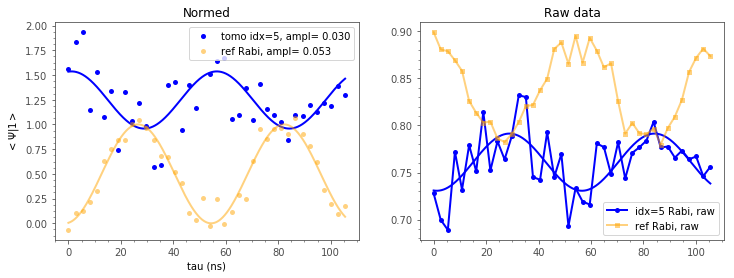

In [13]:
idx = 5
try:
    #plot_rabis_for_tomo(p_raw, list(ref_rabis.values()), idx, zdata='delta')
    plot_rabis_for_tomo(p_raw, list(ref_rabis.values()), idx, zdata='z1')
except:
    logger.exception("")

p_raw[idx]['file'],p_raw[idx]['exp_params']['savetag']

In [14]:
# tomography for pair with given Rabi
rho, fidelity, err_sph = np.nan, np.nan, np.nan
try:
    savetag = p_raw[idx]['exp_params']['savetag']
    on_nv = p_raw[idx]['exp_params']['rabi_on_nv']
    tomo_rabis_i = [rab for rab in tomo_rabis.values() if rab['exp_params']['savetag'] == savetag][0]
    ref_rabis_i = [r for r in ref_rabis.values() if r['exp_params']['rabi_on_nv'] == on_nv][0]
    
    rabi_pair = _get_fit_rabi_pairs(tomo_rabis_i, tomo_rabis)
    rho = tomography_1q_from_2rabi(rabi_pair, ref_rabis_i)
    rho_no_dec = rho_no_decoh(rho)
    
    vec_sph = to_spherical(rho)
    
    #rho_opt = get_opt_rho(p_raw[idx], apply_rot=True)
    
    # apply other unitary than what stored in mes
    u_custom = get_u_gate(p_raw[idx]) 
    #u_pi = np.kron(np.asarray([[0,1],[1,0]]), np.eye(2))  # NOT1
    #u_pi = np.kron( np.eye(2), np.asarray([[0,1],[1,0]]))  # NOT2
    #u_custom = np.matmul(u_pi, u_custom)
    rho_opt = get_opt_rho(p_raw[idx], apply_rot=True, u_custom=u_custom)
    
    #rho_opt = get_opt_rho(p_raw[idx], apply_rot=False)
            
    #rho_opt = get_opt_rho(p_raw[idx], apply_rot=False)
    rho_opt = partial_trace(rho_opt, on_nv-1)
    # manually fixing opt density matrix
    #rho_opt = np.asarray([[1, 0],[0,0]])
    
    fidelity = state_fidelity(rho, rho_opt)
    fidelity_no_dec = state_fidelity(rho_no_dec, rho_opt)
    on_eq = (on_nv==1 and 'c2not1' in savetag) or (on_nv==2 and'c1not2' in savetag) 
    err_sph = err_spherical(rho, rho_opt, on_equator=on_eq)
    
except:
    logger.exception("")
on_nv, rho, (fidelity, fidelity_no_dec), err_sph, vec_sph

(2, array([[ 0.989+0.j   , -0.004+0.039j],
       [-0.004-0.039j,  1.521+0.j   ]]), (1.5212838298449327, 0.9945510124252046), array([ -0.462,  -8.467, -96.008]), array([ 0.538,  2.994, -1.676]))

In [ ]:
rho_opt

In [ ]:
uy = np.conjugate(np.sqrt(1/2)*np.asarray([[1,1],[-1,1]]))
np.matmul(np.matmul(uy, rho_opt), uy. T), np.matmul(np.matmul(uy, rho), uy. T),

In [ ]:
p_raw

In [ ]:

from qutip.visualization import *

#plt.figure(figsize=(6,3))
try:
    fig, ax = matrix_histogram(np.real(rho), limits=[-1,1], title='real', colorbar=True)    
    matrix_histogram(np.imag(rho), limits=[-1,1], title='imag')
except:
    logger.exception("")

plt.show()

In [ ]:
stag1 = list(rabi_pair.values())[0]['exp_params']['savetag']
stag2 = list(rabi_pair.values())[1]['exp_params']['savetag']
stag1, stag2

In [ ]:
# yield vit result for current Rabi pair
# [A1, A2, y0]
# function: y0 + A1*cos() + A2*sin()
[r['fit_res'] for r in rabi_pair.values()]

### plot on Bloch

(2, array([[ 0.989+0.j   , -0.004+0.039j],
       [-0.004-0.039j,  1.521+0.j   ]]))

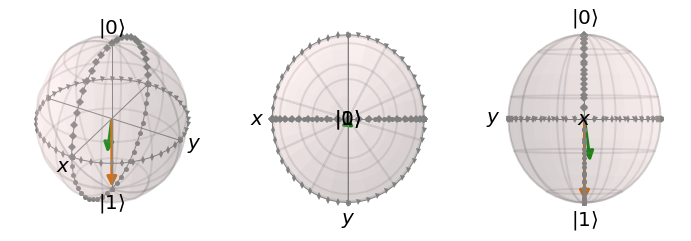

In [15]:

# transformation to apply to experimental state
# here, revert the last pi2_y
u =  np.conjugate(np.sqrt(1/2)*np.asarray([[1,1],[-1,1]]))


try:
    
    views = [(-60,30),(0,90),(90,0)] 
    fig = plt.figure(figsize=(12,4))
    
    for idx, v in enumerate(views):
        
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        
        b = qutip.Bloch(fig=fig, axes=ax)
        rho_q = qutip.Qobj(rho)
        
        if on_eq:
            rho_equator = qutip.Qobj(np.matmul(np.matmul(u, rho), u.conj().T)) if not np.isscalar(u) else rho_q
            vec_eq_no_dec = spherical_2_cart(to_spherical(rho_equator, no_decoherence=True))
            rho_no_dec = qutip.Qobj(rho_no_decoh(rho_equator)) 
            rho_opt_eq = qutip.Qobj(np.matmul(np.matmul(u, rho_opt), u.conj().T)) if not np.isscalar(u) else rho_opt
            b.add_states(rho_equator)
            b.add_states(rho_opt_eq)
            #b.add_states(rho_no_dec)
            b.add_vectors(vec_eq_no_dec)
        else:
            rho = qutip.Qobj(rho) 
            vec_no_dec = spherical_2_cart(to_spherical(rho, no_decoherence=True))
            rho_opt = qutip.Qobj(rho_opt)
            b.add_states(rho)
            b.add_states(rho_opt)
            
        
        b.view = v
        ax.view_init(elev=v[1], azim=v[0])
        b.render(fig=fig, axes=ax)

    b.show()
    
    plt.show()
except:
    logger.exception("")

on_nv, np.asarray(rho_q, dtype=complex) #,np.asarray(rho_equator)


## Load multiple tomo data sets

In [5]:
def find_all_files_for_mes(p_mes):

    path = os.path.normpath(p_mes['file'])
    # offset for erasing automatic "nv_" previx
    p_file = path.split(os.sep)[-1]
    folder = os.path.join(*path.split(os.sep)[:-1])

    savetag_with_date = p_file.split('_pulsed')[0]  
    # find files that have same savetag
    files_in_folder = Tk_file.list_mult_pulsed_mes(folder, filter_strs=[savetag_with_date], incl_subdir=False)

    return files_in_folder

def move_to_folder(fname, target_path):
    # todo: need all files belonging to mes
    fname = os.path.normpath(fname)
    pmes = Tk_file.load_pulsed_result(fname)
    target_path = os.path.normpath(target_path)
    
    try:
        os.makedirs(target_path)
    except OSError:
        pass
    
    all_files = find_all_files_for_mes(pmes)
    if not all_files:
        raise FileNotFoundError
    for file in all_files:
        fname = os.path.basename(file)
        os.rename(file, target_path + os.sep + fname)
    
    return 

def init_2_str(tomo_init):
    if tomo_init == TomoInit.none:
        return "0,0"
    elif tomo_init == TomoInit.ux180_on_2:
        return "0,1"
    elif tomo_init == TomoInit.ux180_on_1:
        return "1,0"
    elif tomo_init == TomoInit.ux180_on_both:
        return "1,1"
    else:
        raise NotImplemented("")
    
def create_folder_name_tomo(pmes):
    savetag = pmes['exp_params']['savetag']
    on_nv = pmes['exp_params']['rabi_on_nv']
    init = pmes['exp_params']['init_state']
    rot = pmes['exp_params']['rotation']
    tau_cnot = pmes['exp_params']['tau_cnot']

    target_path = os.path.normpath(inpath + f"/tau={1e9*tau_cnot:.1f}ns/init={init_2_str(init)}")
    return target_path
    
#target_path = create_folder_name_tomo(p_raw[0])
#move_to_folder(p_raw[0], target_path)

#target_path

def get_n_next_mes(fname, filter_str=None, n=1):
    
    from pathlib import Path
    fname = Path(fname).absolute()
    
    inpath = str(fname.parent.absolute())
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)
    fnames = [os.path.abspath(f) for f in fnames]
    fnames.sort(key=lambda x: os.path.getmtime(x))
    
    idx_file = fnames.index(str(fname))
    
    if n>0:
        return fnames[idx_file:idx_file+n]
    else:
        return fnames[idx_file+n:idx_file]
    


In [ ]:
ref_files

In [ ]:
os.path.exists('D:\\Data\\2022\\07\\20220708\\PulsedMeasurement\\tomo_test_cnot_xy8_o=4_2\\20220708-1705-02_tomography_on1_rot=none_phi=90_init_none_tau_cnot=-360.0ns_pulsed_measurement.dat')

### Move files to correct folder structure

In [6]:
#inpath = r"D:\Data\2022\07\20220715\PulsedMeasurement\tomot_test_kdd_1"
#inpath = r"D:\Data\2022\07\20220720\PulsedMeasurement\pi-pulse-fidelty"
inpath = r"D:\Data\2022\08\20220805\PulsedMeasurement\cnot-fidelty_controlled"
do_move = True
filter_strs = ['pulsed_measurement', '.dat']

str_last_mes = ['c1not2', 'phi=0']
#str_last_mes = ['ux180_on_1', 'ux180_on_2']
n_mes_from_last_mes = -5

fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)
debug = []

for f in fnames:
    if str_last_mes[0] in f and str_last_mes[1] in f:
        try:
            p_i = Tk_file.load_pulsed_result(f)
            target_folder = create_folder_name_tomo(p_i)

            move_files = get_n_next_mes(f, n=-n_mes_from_last_mes)
            move_files.append(f)

            try:
                os.makedirs(target_folder)
            except OSError:
                pass

            debug.append([target_folder, move_files])
            for p_i in move_files:
                logger.debug(f"For {os.path.basename(f)} Moving {os.path.basename(p_i)} to {target_folder}")
                if do_move:
                    move_to_folder(p_i, target_folder)
        except:
            logger.exception("")


In [ ]:
target_folder

### Run fits

In [ ]:
[x[0] for x in os.walk(root_path)]

In [22]:
#root_path = r"D:\Data\2022\07\20220715\PulsedMeasurement\tomot_test_kdd_1"
#root_path = r"D:\Data\2022\07\20220721\PulsedMeasurement\pi-pulse-fidelty"
root_path = r"D:\Data\2022\08\20220805\PulsedMeasurement\cnot-fidelty_controlled"
inpaths = [x[0] for x in os.walk(root_path) if "tau_cnot" in x[0]] # Change from init= to init_


filter_strs = ['pulsed_measurement', '.dat']
#filter_strs += ['rabi']

len(inpaths)

6

In [ ]:
tomo_rabis

In [32]:
res = []

for i_path, inpath in enumerate(inpaths):
    # LOAD
    p_raw, x, y, fnames = [], [], [], []
    tomo_rabis, ref_rabis = {}, {}

    try:
        fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

        for f in fnames:
            p_i = Tk_file.load_pulsed_result(f)
            p_raw.append(p_i)

        tomo_rabis, ref_rabis = fit_rabis(p_raw, zdata='delta')  # 'z1'
        #tomo_rabis, ref_rabis = fit_rabis(p_raw, zdata='z1')  # 'z1'
    except:
        logger.exception(f"While loading from path: {inpath}")
        break
    
   
    done_tomos = []
    
    for idx in range(0, len(p_raw)):
        # loop over all tomo rabis    
        rho, fidelity = np.nan, np.nan
        success_tomo = False
        
        
        try:
            savetag = p_raw[idx]['exp_params']['savetag']
            on_nv = p_raw[idx]['exp_params']['rabi_on_nv']
            init = p_raw[idx]['exp_params']['init_state']
            rot = p_raw[idx]['exp_params']['rotation']
            if (on_nv, init, rot) in done_tomos:
                logger.debug(f"Continueing with done_tomos: {done_tomos}")
                continue
            
            tomo_rabis_i = [rab for rab in tomo_rabis.values() if rab['exp_params']['savetag'] == savetag][0]
            ref_rabis_i = [r for r in ref_rabis.values() if r['exp_params']['rabi_on_nv'] == on_nv][0]

            rabi_pair = _get_fit_rabi_pairs(tomo_rabis_i, tomo_rabis)
            rho = tomography_1q_from_2rabi(rabi_pair, ref_rabis_i)
            rho_no_dec = rho_no_decoh(rho)
            success_tomo = True  # fidelity may fail for badly normed state, still save rho
            done_tomos.append((on_nv, init, rot))
            
            rho_opt = get_opt_rho(p_raw[idx], apply_rot=True)
            
            # apply other unitary than what stored in mes
            #u_custom = get_u_gate(p_raw[idx]) 
            #u_pi = np.kron(np.asarray([[0,1],[1,0]]), np.eye(2))  # NOT1
            #u_pi = np.kron( np.eye(2), np.asarray([[0,1],[1,0]]))  # NOT2
            #u_custom = np.matmul(u_pi, u_custom)
            #rho_opt = get_opt_rho(p_raw[idx], apply_rot=True, u_custom=u_custom)
            
            
            rho_opt = partial_trace(rho_opt, on_nv-1)
        
            # manually fixing opt density matrix
            #rho_opt = np.asarray([[1, 0],[0,0]])
            
            fidelity = state_fidelity(rho, rho_opt)
            fidelity_no_dec = state_fidelity(rho_no_dec, rho_opt)
        
            on_eq = (on_nv==1 and 'c2not1' in savetag) or (on_nv==2 and'c1not2' in savetag) 
            err_sph = err_spherical(rho, rho_opt, on_equator=on_eq)
            
            err_msg = ''
        except Exception as e:
            err_msg = str(e)
            # todo: this is dangerous to fail silently
        if not success_tomo:
            logger.debug(f"Skipping failed tomos: {savetag}: {err_msg}")
            continue
        logger.debug(f"At idx, inpath= {idx}, {inpath}")
        try:
            res.append({'on_nv':on_nv, 'rho': rho, 'F': fidelity, 'F_no_dec':fidelity_no_dec,
                        'sph_err': err_sph , 'init': init,
                        'path': inpath, 'data': p_raw[idx]})
        except:
            logger.exception("")
        


In [19]:
rho_opt

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [21]:
res[0]

{'on_nv': 1, 'rho': array([[0.57 +0.j   , 0.098-0.294j],
       [0.098+0.294j, 0.452+0.j   ]]), 'F': nan, 'F_no_dec': 0.9945510124252046, 'sph_err': array([ -0.462,  -8.467, -96.008]), 'init': <TomoInit.ux180_on_both: 9>, 'path': 'D:\\Data\\2022\\08\\20220805\\PulsedMeasurement\\cnot-fidelty_controlled\\tau_cnot=-200ns', 'data': {'data':              tau        z1        z2      std1      std2
0   0.000000e+00  0.752086  0.726230  0.012028  0.011759
1   2.610000e-09  0.712646  0.738727  0.011496  0.011842
2   5.220000e-09  0.714701  0.745766  0.011705  0.011965
3   7.830000e-09  0.743267  0.700022  0.011910  0.011396
4   1.044000e-08  0.699317  0.695296  0.011354  0.011422
5   1.305000e-08  0.757148  0.772127  0.012119  0.012273
6   1.566000e-08  0.663916  0.768318  0.011099  0.012162
7   1.827000e-08  0.681286  0.751160  0.011249  0.012053
8   2.088000e-08  0.760551  0.765136  0.012100  0.012226
9   2.349000e-08  0.723607  0.752039  0.011675  0.012050
10  2.610000e-08  0.699798  0.742

In [33]:
[(r['on_nv'], r['F'], r['rho'], (r['path'].rsplit("\\"))[-2:]) for r in res]

[(1, 0.5695060348618752, array([[0.57 +0.j   , 0.098-0.294j],
       [0.098+0.294j, 0.452+0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-200ns']), (2, 0.7503090163649194, array([[0.202+0.j   , 0.061-0.035j],
       [0.061+0.035j, 0.75 +0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-200ns']), (2, nan, array([[0.163+0.j   , 0.006-0.109j],
       [0.006+0.109j, 0.844+0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-200ns']), (1, nan, array([[ 0.039+0.j   , -0.015-0.004j],
       [-0.015+0.004j,  0.96 +0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-200ns']), (1, 0.5909664831636666, array([[0.591+0.j   , 0.086-0.271j],
       [0.086+0.271j, 0.419+0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-240ns']), (2, 0.7680600874897477, array([[0.183+0.j   , 0.014-0.025j],
       [0.014+0.025j, 0.768+0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-240ns']), (2, nan, array([[-0.062+0.j   ,  0.025+0.044j],
       [ 0.025-0.044j,  1.013+0.j   ]]), ['cnot-fidelty_controlled', 'tau_cnot=-240

### Plot fidelity and coherent phase vs tau_cnot

In [ ]:
extract_num_from_path(res[0]['data']['file'])[-1]

In [34]:
rot = TomoRotations.c2not1
#rot = TomoRotations.none
plot_on_nv = [1,2]

#(r['F'], r['rho'],
#float(extract_num_from_path(r['data']['file'])[-1]) == -65.0
# this x may depend on order in res, so xs is the safer way to do
#x = np.unique([float(extract_num_from_path(r['data']['file'])[-1]) for r in res])
x = np.unique([r['data']['exp_params']['tau_cnot']*1e9 for r in res])
#x = np.unique([r['data']['exp_params']['pulse_error']*1e9 for r in res])
inits = np.unique([r['init'] for r in res])
inits = [TomoInit(i) for i in inits]

xs, fs, sph_errs, rhos, params = [], [], [], [], []


def _get_pulse_error(res):
    try:
        return res['data']['exp_params']['pulse_error']*1e9 
    except KeyError:
        return res['data']['exp_params']['pulse_error2']*1e9 

for init in inits:
    for on_nv in plot_on_nv:
        x_i = np.asarray([#float(extract_num_from_path(r['data']['file'])[-1]) for r in res 
                          r['data']['exp_params']['tau_cnot']*1e9 for r in res
                          #_get_pulse_error(r) for r in res
                          if r['data']['exp_params']['init_state'] == init 
                          and r['data']['exp_params']['rabi_on_nv'] == on_nv
                          and r['data']['exp_params']['rotation'] == rot])
        f_i = np.asarray([r['F'] for r in res 
                          if r['data']['exp_params']['init_state'] == init 
                           and r['data']['exp_params']['rabi_on_nv'] == on_nv
                           and r['data']['exp_params']['rotation'] == rot], dtype=object)
        f_nodec_i = np.asarray([r['F_no_dec'] for r in res 
                          if r['data']['exp_params']['init_state'] == init 
                           and r['data']['exp_params']['rabi_on_nv'] == on_nv
                           and r['data']['exp_params']['rotation'] == rot], dtype=object)
        sph_err_i = np.asarray([r['sph_err'] for r in res 
                          if r['data']['exp_params']['init_state'] == init 
                           and r['data']['exp_params']['rabi_on_nv'] == on_nv
                           and r['data']['exp_params']['rotation'] == rot], dtype=object)
        rho_i = np.asarray([r['rho'] for r in res
                            if r['data']['exp_params']['init_state'] == init 
                            and r['data']['exp_params']['rabi_on_nv'] == on_nv
                            and r['data']['exp_params']['rotation'] == rot], dtype=object)
        params_i = {'init': init.name, 'on_nv': on_nv}
        
        x_i, f_i, f_nodec_i, rho_i, sph_err_i = np.sort(x_i), f_i[x_i.argsort()], \
              f_nodec_i[x_i.argsort()], rho_i[x_i.argsort()], sph_err_i[x_i.argsort()]
        xs.append(x_i)
        fs.append([f_i,f_nodec_i])
        sph_errs.append(sph_err_i)
        rhos.append(rho_i)
        params.append(params_i)
        


In [26]:
res[0]['data']['exp_params']['rabi_on_nv']

1

In [27]:
rhos

[array([[[(0.6306392868092414+0j),
         (0.07662962778766919-0.24897060350147898j)],
        [(0.07662962778766919+0.24897060350147898j),
         (0.3778736584611297+0j)]],

       [[(0.5898078425203951+0j),
         (0.10625593211913587-0.2832663197220758j)],
        [(0.10625593211913587+0.2832663197220758j),
         (0.4241904557734895+0j)]],

       [[(0.601254155324009+0j),
         (0.06825165313341641-0.2796261203095142j)],
        [(0.06825165313341641+0.2796261203095142j),
         (0.41223011550340893+0j)]],

       [[(0.5818860607507272+0j),
         (0.12144717771393729-0.24517296216763623j)],
        [(0.12144717771393729+0.24517296216763623j),
         (0.40824714882547175+0j)]],

       [[(0.5909664761488365+0j),
         (0.0856889543342137-0.27099262362556786j)],
        [(0.0856889543342137+0.27099262362556786j),
         (0.4191229759426442+0j)]],

       [[(0.5695060348618749+0j),
         (0.09837230368501387-0.2943478158904952j)],
        [(0.098372303685013

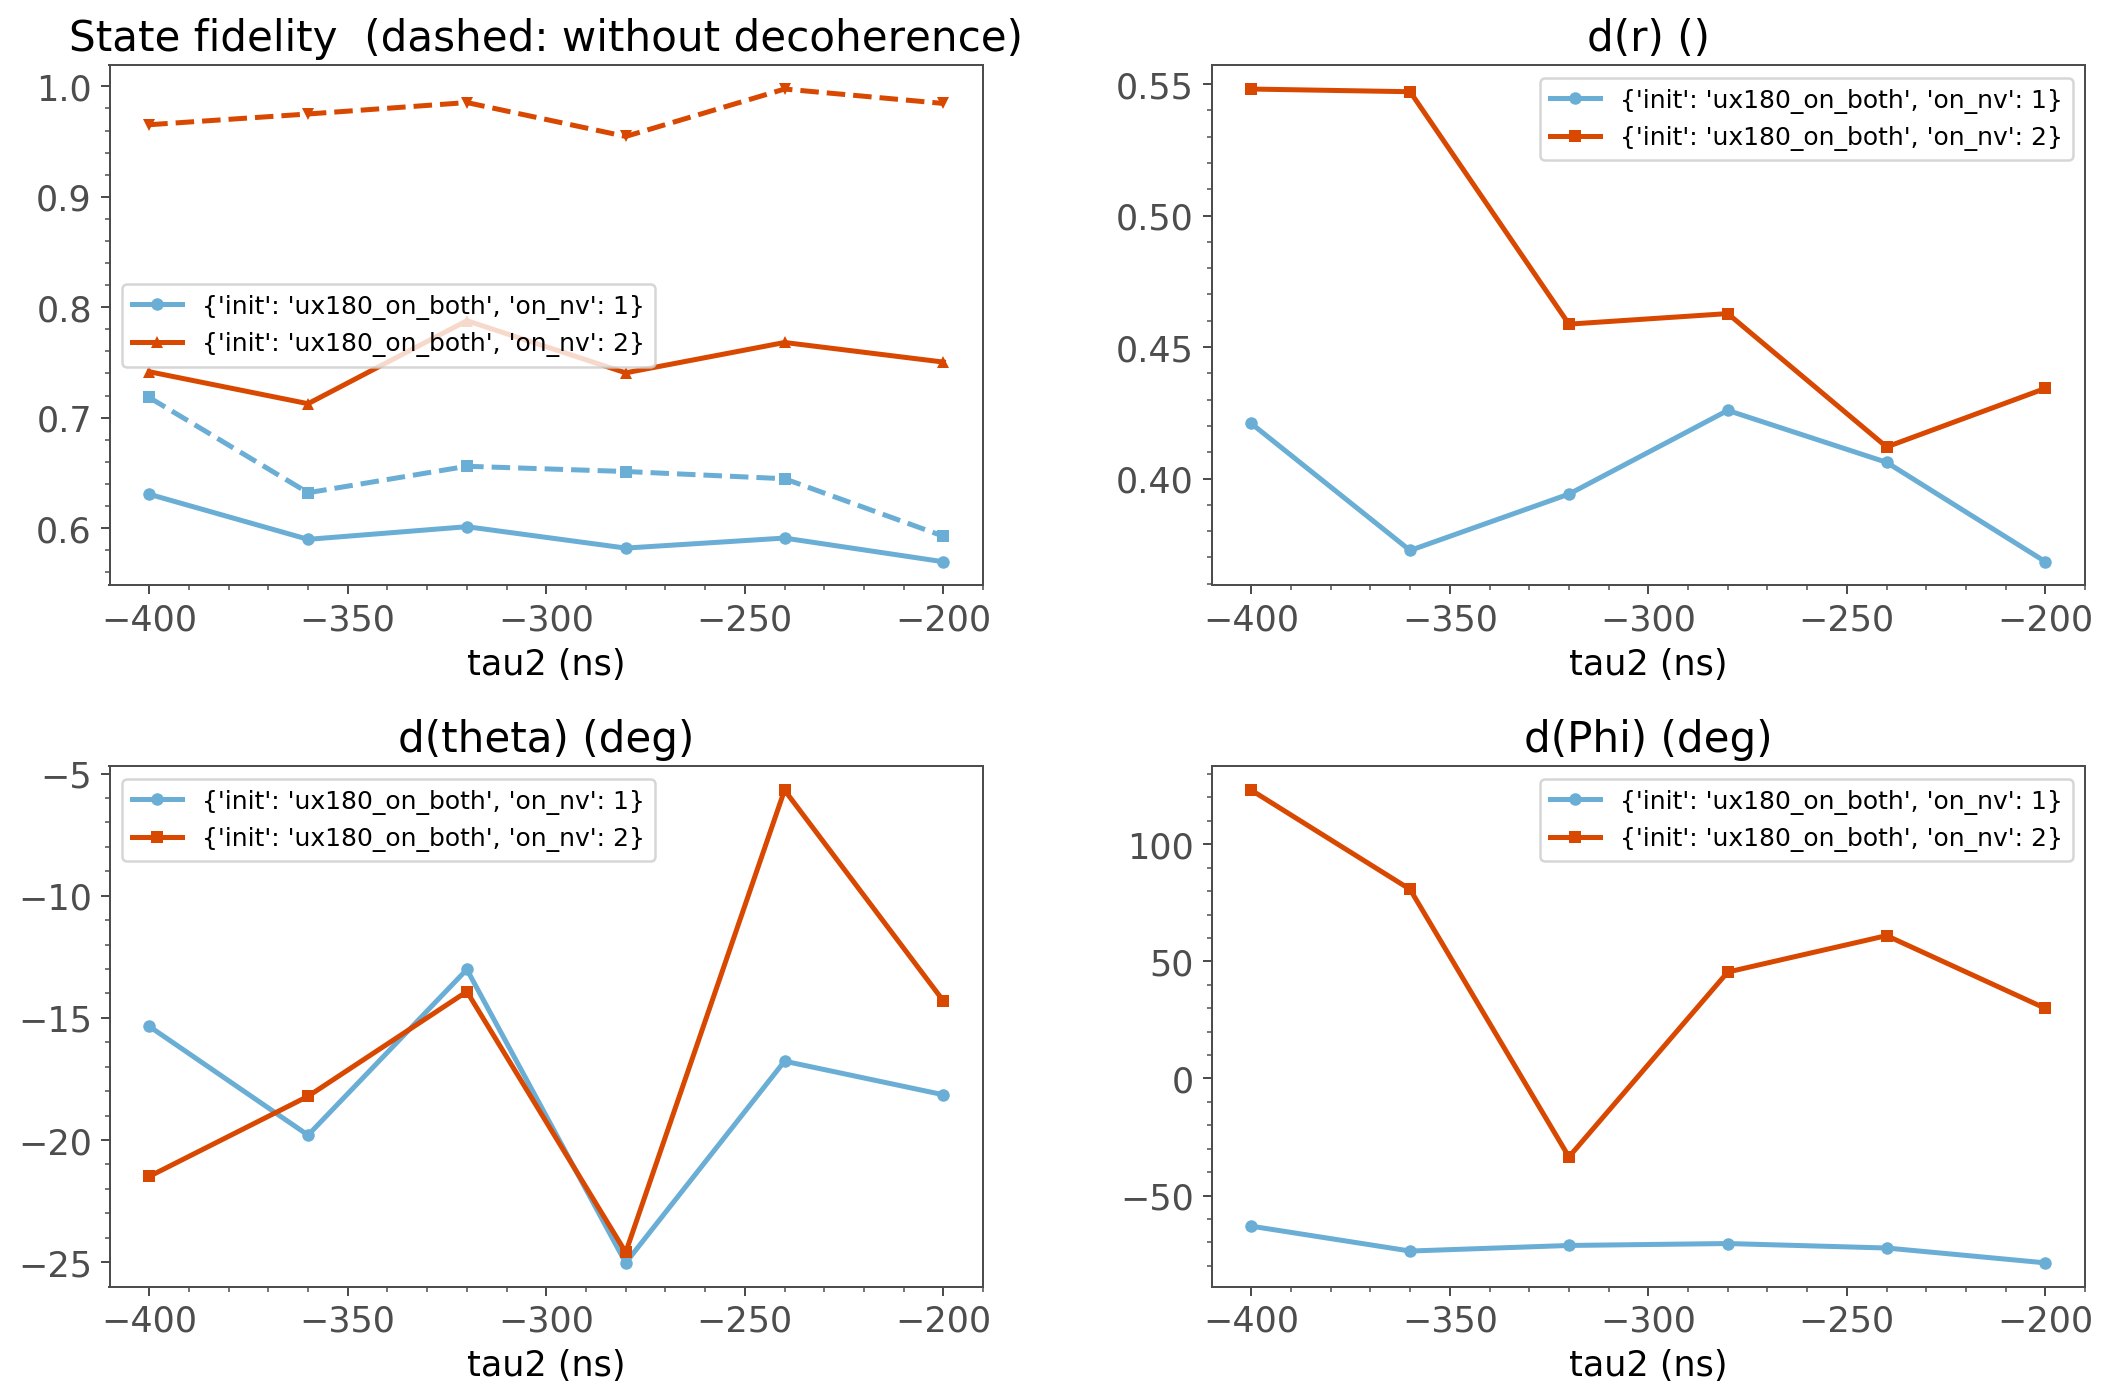

In [35]:
plt.figure(figsize=(12,8))
plt.subplot(221)

try:
    for i, f in enumerate(fs):
        color = plt.cm.Blues(0.5+0.5*i/len(params)) if params[i]['on_nv']==1 else plt.cm.Oranges(0.5+0.5*i/len(params))
        fid, fid_no_dec = f[0], f[1]
        plt.plot(xs[i], fid, label=f"{params[i]}", color=color)
        plt.plot(xs[i], fid_no_dec, color=color, linestyle="--")
    
    plt.xlabel("tau2 (ns)")
    plt.title("State fidelity  (dashed: without decoherence)")
    plt.legend(prop={'size': 10})
    
    plt.subplot(222)
    
    for i, sph_err in enumerate(sph_errs):
        color = plt.cm.Blues(0.5+0.5*i/len(params)) if params[i]['on_nv']==1 else plt.cm.Oranges(0.5+0.5*i/len(params))
        #rho00 = np.asarray([r[0,0] for r in rho])
        #rho11= np.asarray([r[1,1] for r in rho])
        err_r = [abs(r[0]) for r in sph_err]
        #plt.plot(xs[i], rho00-rho11, label=f"{params[i]}", color=color)
        plt.plot(xs[i], err_r, label=f"{params[i]}", color=color)
    
    plt.xlabel("tau2 (ns)")
    plt.title("rho[1,1]-rho[0,0]")
    plt.title("d(r) ()")
    plt.legend(prop={'size': 10})

    plt.subplot(223)

    for i, sph_err in enumerate(sph_errs):
        color = plt.cm.Blues(0.5+0.5*i/len(params)) if params[i]['on_nv']==1 else plt.cm.Oranges(0.5+0.5*i/len(params))
        #rho01 = [r[0,1] for r in rho]
        err_th = [r[1] for r in sph_err]
        #plt.plot(xs[i], abs(np.imag(rho01)), label=f"{params[i]}", color=color)
        plt.plot(xs[i], err_th, label=f"{params[i]}", color=color)
    
    plt.xlabel("tau2 (ns)")
    plt.title("|imag(rho[1,0])|")
    plt.title("d(theta) (deg)")
    plt.legend(prop={'size': 10})

   
    plt.subplot(224)
    
    for i, sph_err in enumerate(sph_errs):
        color = plt.cm.Blues(0.5+0.5*i/len(params)) if params[i]['on_nv']==1 else plt.cm.Oranges(0.5+0.5*i/len(params))
        #rho01 = [r[0,1] for r in rho]
        #plt.plot(xs[i], abs(np.real(rho01)), label=f"{params[i]}", color=color)
        err_phi = [r[2] for r in sph_err]
        plt.plot(xs[i], err_phi, label=f"{params[i]}", color=color)
                 
    #plt.title("|re(rho[1,0])|")
    plt.xlabel("tau2 (ns)")
    plt.title("d(Phi) (deg)")
    plt.legend(prop={'size': 10})

    
    plt.tight_layout()
    plt.show()

except:
    logger.exception("")



In [ ]:
xs

### plot on Bloch

In [ ]:
idx_x = 0
idx_param = 0

# transformation to apply to experimental state
# here, revert the last pi2_y
u = np.conjugate(np.sqrt(1/2)*np.asarray([[1,1],[-1,1]]))


try:
    
    views = [(-60,30),(0,90),(90,0)] 
    fig = plt.figure(figsize=(12,4))
    
    for idx, v in enumerate(views):
        
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        
        rho = np.asarray(rhos[idx_param][idx_x], dtype=complex)
        
        b = qutip.Bloch(fig=fig, axes=ax)
        rho_q = qutip.Qobj(rho)
        rho_equator = qutip.Qobj(np.matmul(np.matmul(u, rho), u.conj().T)) if params[idx_param]['on_nv'] == 1 and not np.isscalar(u) else rho_q
        
        b.add_states(rho_equator)
        b.view = v
        ax.view_init(elev=v[1], azim=v[0])
        b.render(fig=fig, axes=ax)
        
        if idx % 3 == 1:
            ax.set_title(f"{params[idx_param]}, tau= {xs[idx_param][idx_x]} ns", fontsize=10)
    
    b.show()
    
    plt.show()
except:
    logger.exception("")

np.asarray(rho_equator), np.asarray(rhos[idx_param][idx_x], dtype=complex)


In [ ]:
# reset matplotlib style
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:

idx_param = 0

try:
    idx_plot = 1
    n_rows = len(rhos[idx_param])
    views = [(-60,30),(0,90),(90,0)] 
    fig = plt.figure(figsize=(12,4*n_rows))
        
    for i, rho in enumerate(rhos[idx_param]):
        #color = plt.cm.Blues(0.5+0.5*i/len(params)) if params[i]['on_nv']==1 else plt.cm.Oranges(0.5+0.5*i/len(params)) 
        rho = np.asarray(rho, dtype=complex)
        for idx, v in enumerate(views):

            ax = fig.add_subplot(n_rows, 3, idx_plot, projection='3d')
            ax.set_aspect('equal')
            if idx_plot % 3 == 2:
                ax.set_title(f"{params[idx_param]}, tau= {xs[idx_param][i]} ns")

            b = qutip.Bloch(fig=fig, axes=ax)
            if params[idx_param]['on_nv'] == 1 and not np.isscalar(u):
                rho_q = qutip.Qobj(np.matmul(np.matmul(u, rho), u.conj().T))
            else:
                rho_q = qutip.Qobj(rho)
            b.add_states(rho_q)
            b.view = v
            ax.view_init(elev=v[1], azim=v[0])
            b.render(fig=fig, axes=ax)

            idx_plot += 1
                
                

    
    b.show()
    plt.tight_layout()
    plt.show()

except:
    logger.exception("")



In [ ]:
np.asarray(rho_equator)

In [ ]:
qutip.Qobj(rho)

In [ ]:
np.matmul(u, rho)

In [ ]:
rho

In [ ]:
u.get_H()

In [ ]:
u.conj().T

### Plot fidelty of many pi-pulses vs pulse-length-errors

In [ ]:
# from extracted parameter set

#pulse_length_error = []
# fidelty = []
# pi_pulse_quantities = 

ax,fig = plt.subplot()
ax.plot(pulse_length_error,fidelty)
ax.set_xlabel('pulse-length-errors (us)') 
ax.set_ylabel('Fidelty') 
plt.title('Fidelty of ',str( pi_pulse_quantities),' pi-pulses with different pulse-lenght-errors')
plt.show()